In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import os

os.chdir("../Data")

from DataHelper import *

# 1.0 Overview

We will be exploring and cleaning the energy dataset and see if we can make sense of the data given.

In [2]:
df = pd.read_csv("energy_dataset.csv")
pd.DataFrame(df.dtypes, columns = ["Data Type"])

Data Type
time                                           object
generation biomass                            float64
generation fossil brown coal/lignite          float64
generation fossil coal-derived gas            float64
generation fossil gas                         float64
generation fossil hard coal                   float64
generation fossil oil                         float64
generation fossil oil shale                   float64
generation fossil peat                        float64
generation geothermal                         float64
generation hydro pumped storage aggregated    float64
generation hydro pumped storage consumption   float64
generation hydro run-of-river and poundage    float64
generation hydro water reservoir              float64
generation marine                             float64
generation nuclear                            float64
generation other                              float64
generation other renewable                    float64
generation solar                              float64
generation waste                              float64
generation wind offshore                      float64
generation wind onshore                       float64
forecast solar day ahead                      float64
forecast wind offshore eday ahead             float64
forecast wind onshore day ahead               float64
total load forecast                           float64
total load actual                             float64
price day ahead                               float64
price actual                                  float64

The data types in this dataset are consistent, with all quantitative features (numerical ones) being of type float64.

Since our goal is to predict 'total load actual,' we do not require the forecast and price features. However, we will use 'total load forecast' as a benchmark to assess the performance of our models. Therefore, let's separate the benchmark feature from our dataset.

In [3]:
TARGET = "total load actual" # What we are trying to predict
BM = "total load forecast" # Benchmark

load_benchmark = df[["time", BM]]

In [4]:
print(type(df["time"].loc[0]))
df["time"].loc[0]

<class 'str'>


'2015-01-01 00:00:00+01:00'

Our time column contains strings, so we need to convert to datetime object and set it as the index of the dataframe. Also note that the time is in Central European Time (CET).

In [5]:
load_benchmark["time"] = pd.to_datetime(load_benchmark["time"], utc=True).dt.tz_convert("CET")
load_benchmark.set_index("time", inplace=True)

df["time"] = pd.to_datetime(df["time"], utc=True).dt.tz_convert("CET")
df.set_index("time", inplace=True)
df.drop(["forecast solar day ahead", "forecast wind offshore eday ahead", 
                 "forecast wind onshore day ahead","price day ahead","price actual"], axis=1, inplace=True)
print(df.shape)

df.sort_index(inplace=True)
print(f"The timeseries starts at {df.index[0]}.")
print(f"The timeseries ends at {df.index[-1]}.")


(35064, 23)
The timeseries starts at 2015-01-01 00:00:00+01:00.
The timeseries ends at 2018-12-31 23:00:00+01:00.


Let's check if there are any duplicated rows/hour periods.

In [6]:
duplicate_time = df.index.duplicated()
print(f"There are duplicated time? {duplicate_time.any()}")
time_spacing(df)

There are duplicated time? False
This dataframe has 35064 rows.


time
0 days 01:00:00    35063
Name: count, dtype: int64

There are no gaps in our time series! Let's now check if there is any missing data in any of the features.

In [7]:
missing = missing_features(df)
missing

Missing (%)  Missing (Count)
generation biomass                              0.054187               19
generation fossil brown coal/lignite            0.051335               18
generation fossil coal-derived gas              0.051335               18
generation fossil gas                           0.051335               18
generation fossil hard coal                     0.051335               18
generation fossil oil                           0.054187               19
generation fossil oil shale                     0.051335               18
generation fossil peat                          0.051335               18
generation geothermal                           0.051335               18
generation hydro pumped storage aggregated    100.000000            35064
generation hydro pumped storage consumption     0.054187               19
generation hydro run-of-river and poundage      0.054187               19
generation hydro water reservoir                0.051335               18
generation marine                               0.054187               19
generation nuclear                              0.048483               17
generation other                                0.051335               18
generation other renewable                      0.051335               18
generation solar                                0.051335               18
generation waste                                0.054187               19
generation wind offshore                        0.051335               18
generation wind onshore                         0.051335               18
total load actual                               0.102669               36

The column 'generation hydro pumped storage aggregated' is completely empty, so it will be dropped. All other generation columns have approximately 18 to 19 rows missing. The target variable has 36 missing rows, which represents roughly 0.1% of the total data. The benchmark variable has no missing data; therefore, it will be removed from the dataset as we proceed with the analysis.

In [8]:
df.drop(["generation hydro pumped storage aggregated", BM], axis=1, inplace=True)

Now lets get an idea of the descriptive statistics of our energy data.

In [9]:
desc = df.describe().round(3)
desc

generation biomass  generation fossil brown coal/lignite  \
count           35045.000                             35046.000   
mean              383.514                               448.059   
std                85.354                               354.569   
min                 0.000                                 0.000   
25%               333.000                                 0.000   
50%               367.000                               509.000   
75%               433.000                               757.000   
max               592.000                               999.000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0              35046.000   
mean                                  0.0               5622.737   
std                                   0.0               2201.830   
min                                   0.0                  0.000   
25%                                   0.0               4126.000   
50%                                   0.0               4969.000   
75%                                   0.0               6429.000   
max                                   0.0              20034.000   

       generation fossil hard coal  generation fossil oil  \
count                    35046.000              35045.000   
mean                      4256.066                298.320   
std                       1961.601                 52.521   
min                          0.000                  0.000   
25%                       2527.000                263.000   
50%                       4474.000                300.000   
75%                       5838.750                330.000   
max                       8359.000                449.000   

       generation fossil oil shale  generation fossil peat  \
count                      35046.0                 35046.0   
mean                           0.0                     0.0   
std                            0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   

       generation geothermal  generation hydro pumped storage consumption  \
count                35046.0                                    35045.000   
mean                     0.0                                      475.577   
std                      0.0                                      792.407   
min                      0.0                                        0.000   
25%                      0.0                                        0.000   
50%                      0.0                                       68.000   
75%                      0.0                                      616.000   
max                      0.0                                     4523.000   

       ...  generation hydro water reservoir  generation marine  \
count  ...                         35046.000            35045.0   
mean   ...                          2605.115                0.0   
std    ...                          1835.200                0.0   
min    ...                             0.000                0.0   
25%    ...                          1077.250                0.0   
50%    ...                          2164.000                0.0   
75%    ...                          3757.000                0.0   
max    ...                          9728.000                0.0   

       generation nuclear  generation other  generation other renewable  \
count           35047.000         35046.000                   35046.000   
mean             6263.907            60.229                      85.640   
std               839.668            20.238                      14.078   
min                 0.000             0.000                       0.000   
25%     

**Note:** There are multiple columns where the max and min value are 0, implying rows in that column is either 0 or empty.

In [10]:
zero_columns = desc.columns[(desc.loc['min'] == 0) & (desc.loc['max'] == 0)]
generation_columns = [col for col in df.columns if "generation" in col.lower()]
print(zero_columns)
print(set(zero_columns) - set(generation_columns))
print(set(zero_columns) - set(missing.index))

Index(['generation fossil coal-derived gas', 'generation fossil oil shale',
       'generation fossil peat', 'generation geothermal', 'generation marine',
       'generation wind offshore'],
      dtype='object')
set()
set()


From the zero_columns above, they contain a mix of zero and missing values, so we will drop those columns.

In [11]:
df.drop(zero_columns.to_list(), axis=1, inplace=True)

Even though the remaining features with missing data have minimal missing values, I want to better understand the data to ensure temporal continuity. Furthermore, given the insignificant amount of missing data, I believe that imputation will have a minimal impact on the overall analysis.

Let's dive deeper into understanding the target variable and the generation columns.

# 2.0 Target Variable (*Total Load Actual*)

In [12]:
# Hours where the target variable is missing data
tv_missing_index = df.loc[df[TARGET].isna()].index
tv_missing_index[:10]

DatetimeIndex(['2015-01-05 12:00:00+01:00', '2015-01-05 13:00:00+01:00',
               '2015-01-05 14:00:00+01:00', '2015-01-05 15:00:00+01:00',
               '2015-01-05 16:00:00+01:00', '2015-01-05 17:00:00+01:00',
               '2015-01-28 13:00:00+01:00', '2015-02-01 07:00:00+01:00',
               '2015-02-01 08:00:00+01:00', '2015-02-01 09:00:00+01:00'],
              dtype='datetime64[ns, CET]', name='time', freq=None)

From the 36 different hourly periods with missing period, let's consider the first four weeks of data to get better look at the missing values. 

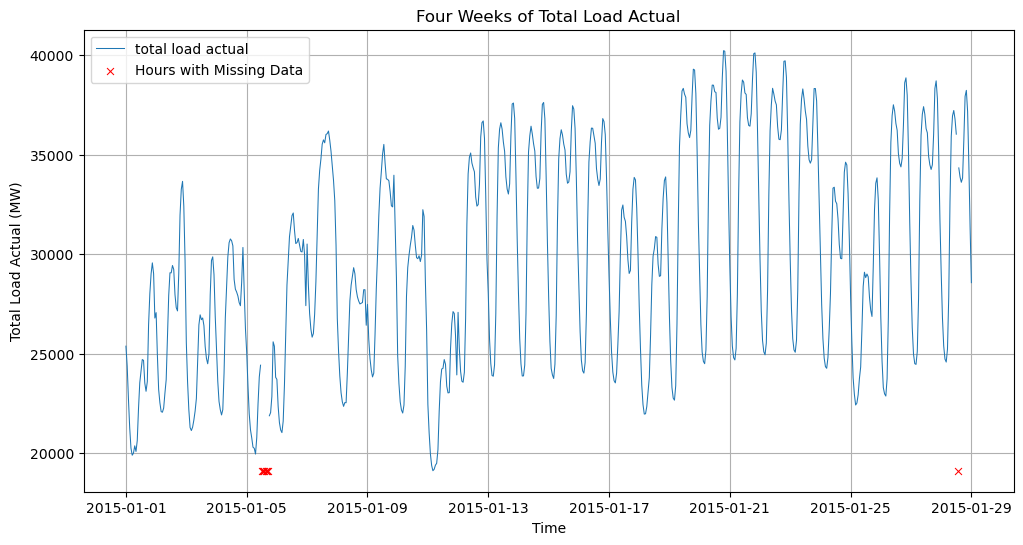

In [13]:
plot_tv_four_weeks(df, TARGET)

From the first four weeks, there is definitely some seasonality in the feature. It is more apparent with the last missing hourly point on 2015-01-28, which appears to me as a daily pattern. Furthermore, from the first four weeks, it also appears to me that on weekends and holidays (ie. New Years) there is a lower demand for electricity.

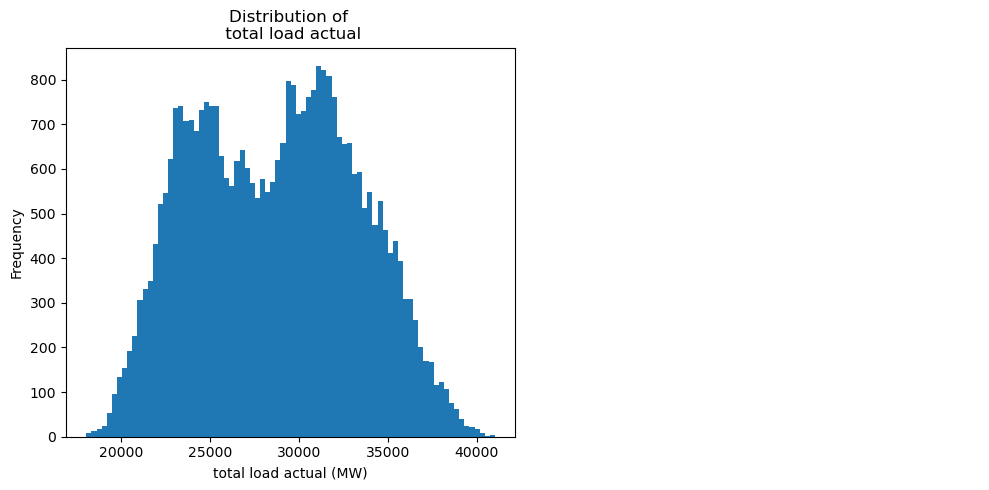

Based on the target variables interquartile range, there are 0 detected.


count          mean         std      min       25%  \
total load actual  35028.0  28696.939905  4574.98795  18041.0  24807.75   

                       50%      75%      max  
total load actual  28901.0  32192.0  41015.0

In [14]:
plot_energy_histograms(df, [TARGET], 80)
print(f"Based on the target variables interquartile range, there are {len(find_outliers(df[TARGET]))} detected.")
df[[TARGET]].describe().T

From the histogram above, the target variable displays a bimodal distribution. The two peaks may suggest that there are different clusters of demand, which could be related to the different times of day or seasons. Now considering the outliers, there does not seem to be any, although there are very few values greater than 40,000 MW which we should note down.

In [15]:
tv_extreme = df[df[TARGET]> 40000].index
extreme_dates = np.unique(tv_extreme.date)
extreme_dates

array([datetime.date(2015, 1, 20), datetime.date(2015, 1, 21),
       datetime.date(2015, 4, 2), datetime.date(2015, 5, 2),
       datetime.date(2015, 9, 2), datetime.date(2016, 6, 9),
       datetime.date(2017, 1, 18), datetime.date(2017, 1, 19),
       datetime.date(2017, 1, 20), datetime.date(2018, 5, 2),
       datetime.date(2018, 6, 2), datetime.date(2018, 7, 2),
       datetime.date(2018, 8, 2)], dtype=object)

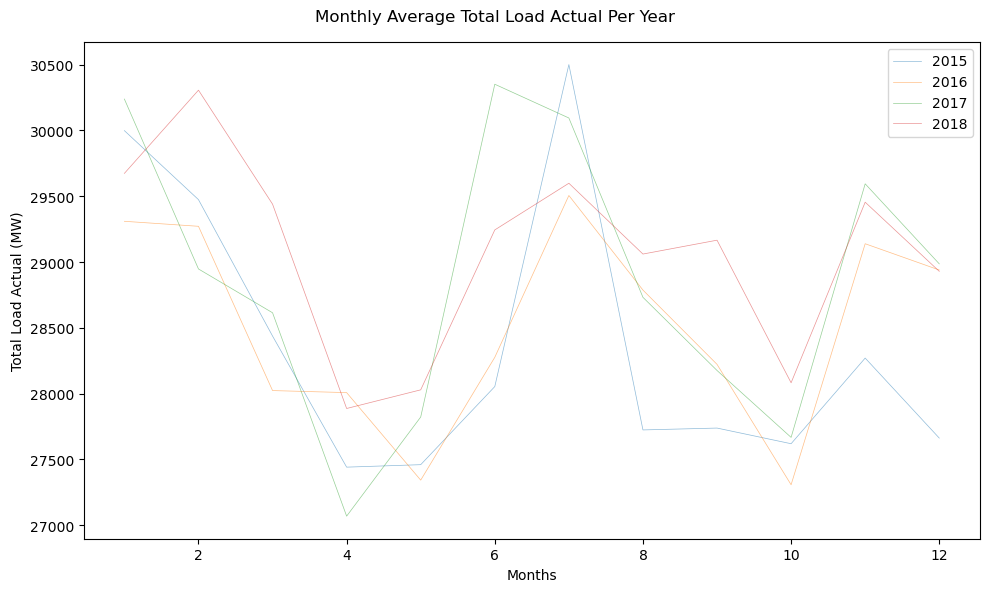

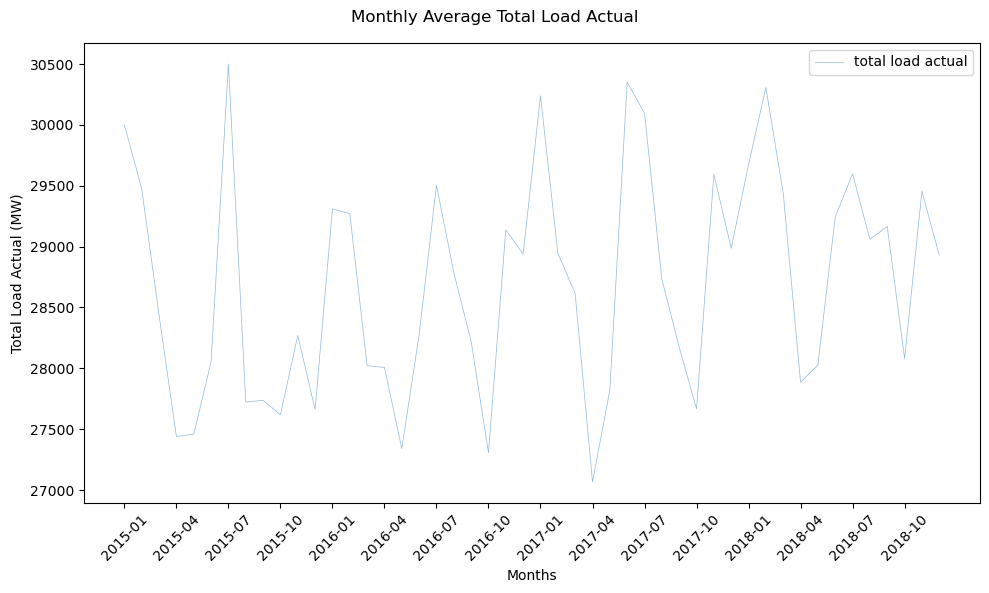

In [16]:
plot_monthly_avg_load_per_year(df, TARGET)
plot_monthly_avg_load(df, TARGET)

The line plots displays some seasonality, where we see earlier months (January to February) and middle of the year (June to July) peak on average per year. This trend is most likely due to the fact that in this months, temperatures are at there most extreme (being very cool or very hot) requiring additional load for heating and cooling.

**Note:** This suggests that adding a time-based feature, such as months, could provide a better explanation of the target variable. Additionally, including a feature that indicates the season could be very valuable.

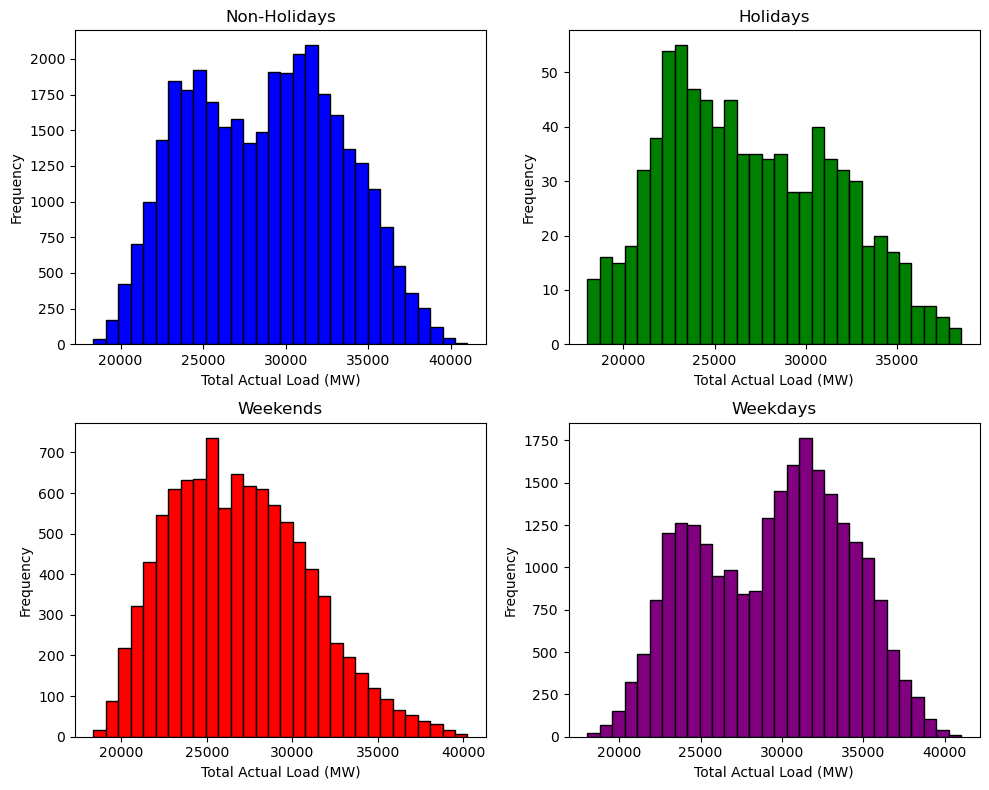

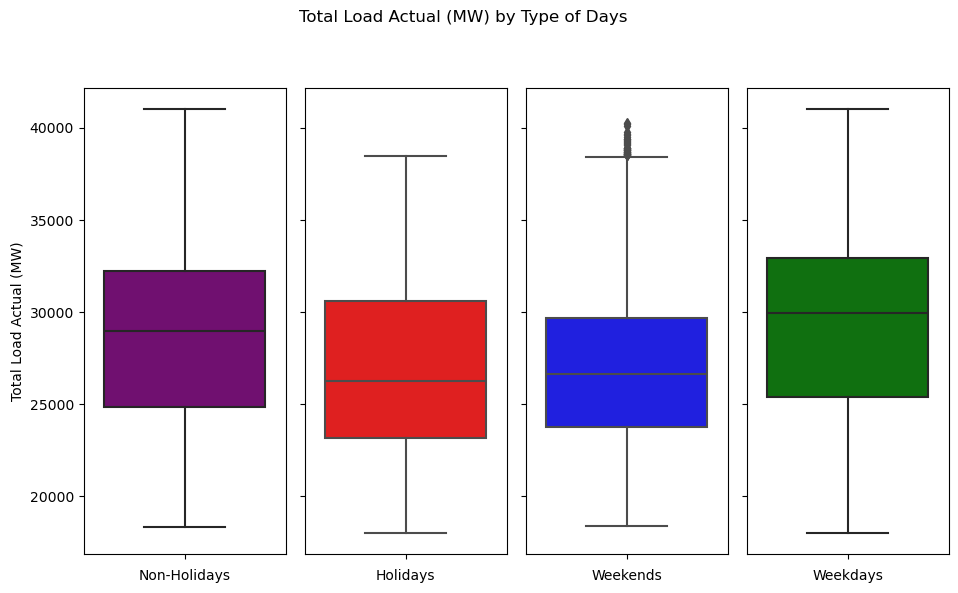

In [17]:
plot_energy_dist_target(df, TARGET)
plot_energy_comp_target(df, TARGET)

**Median:**

Comparing non-holidays with holidays, we observed that non-holidays have a higher median energy consumption. This result may be attributed to reduced industrial activities and more people being at home during non-holidays. However, the median energy consumption does not decrease significantly when comparing weekdays with weekends, suggesting that holiday-specific activities or events might require substantial energy. In contrast, energy demand is generally higher during weekdays compared to weekends. This is likely due to increased industrial, commercial, and institutional activities that are more prominent on weekdays.

**IQR:**

Both weekdays and non-holidays exhibit a wider interquartile range (IQR) compared to weekends and holidays, indicating greater variability in energy consumption during these periods. This variability might be due to differing levels of industrial, commercial, and residential energy use. The IQR is narrower for weekends and holidays, suggesting more consistent energy usage patterns during these days. This consistency may be attributed to more predictable and routine energy use in households, as opposed to the variability caused by business operations during the workweek.

**Outliers:**

A few outliers are observed on weekends, indicating occasional spikes in energy consumption that are not typical for these days. These outliers could be the result of special events, weather conditions that increase heating or cooling demands, or other anomalies such as maintenance activities that impact energy use.

**Overall:**

Each category shows relative symmetry with no severe skewness, except for a slight skew on weekends due to outliers. When imputing missing data, it is important to consider the distinct patterns associated with different types of days, such as matching missing data from a holiday with data from another holiday. Additionally, incorporating new features into the dataset, such as binary indicators for holidays and weekends, could provide better insights into the target variable.

**Note:** This suggests that adding features that indicates whether a day is holiday or weekday could provide a better explanation of the target variable.

The number of rows in the target variable where there is missing data is 36
The number of rows in the target variable where there is missing data on a holiday is 0


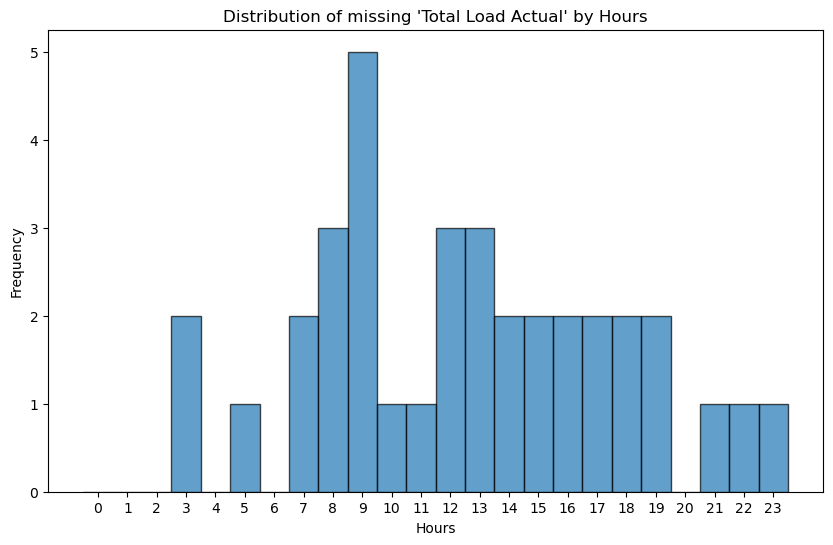

In [18]:
plot_missing_by_hour(df, TARGET)

The target variable is not missing any data on a holiday and appears to be missing the most data at 9 a.m.

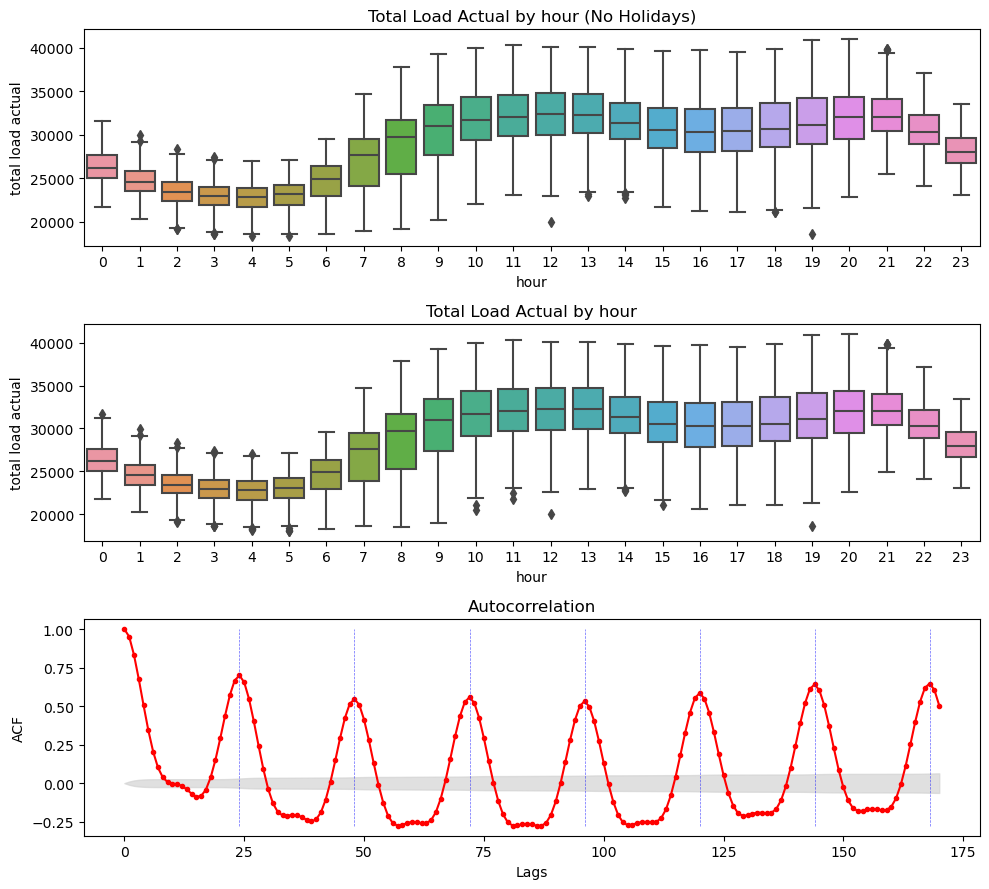

In [19]:
plot_tv_by_the_hour(df, TARGET, True)

Both plots reveal a distinct daily cycle, characterized by lower loads during the early morning hours (midnight to 5 a.m.) and a gradual increase throughout the day. The ACF plot further underscores this pattern by indicating strong seasonality, suggesting that the 'Total Load Actual' values exhibit similar patterns each day. The highest correlation values are observed at lag 24 (the previous day) and continue to peak every 24 hours until lag 168 (the previous week). This slow decay in autocorrelation reinforces the presence of strong seasonality in the target variable.

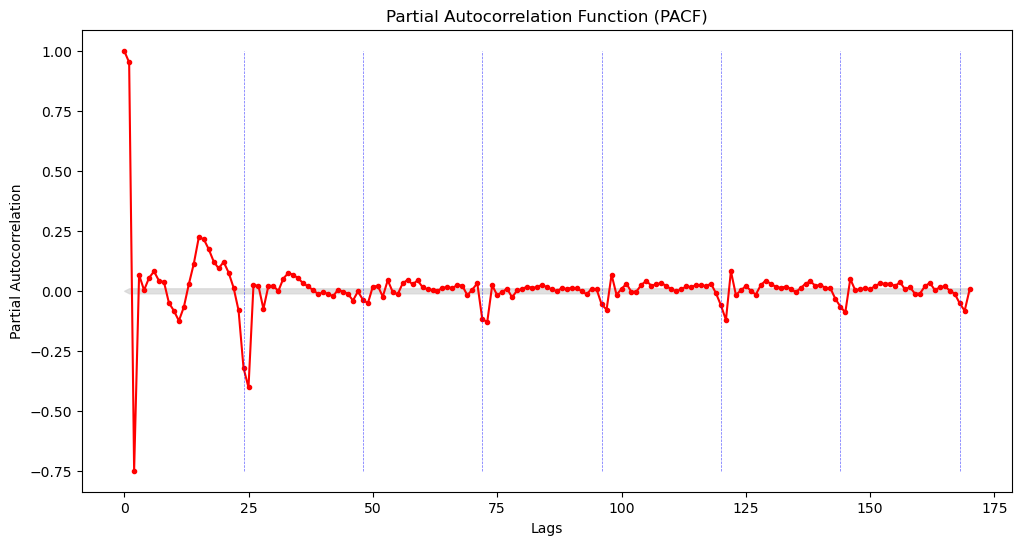

In [20]:
plot_pacf(df, TARGET, 170, True)

From the PACF plot, there is a strong spike at lag 1, which suggests that the immediate past value has a strong direct relationshp with the current value of the time series. From lag 2 to 26, the PACF shows weaker and more erratic behaviour for the short lags. This suggests that once lag 1 is accounted for, the influence of immediate subsequent lags are not as strong. Further out, the PACF starts to flatten and oscillate around zero. 


From the plots above, let's consider lag 1 and 24 alongside the target variable for three days. We will start at the 288th row (2015-01-13) to avoid the New Year’s effect.

Plot with 3 Days:


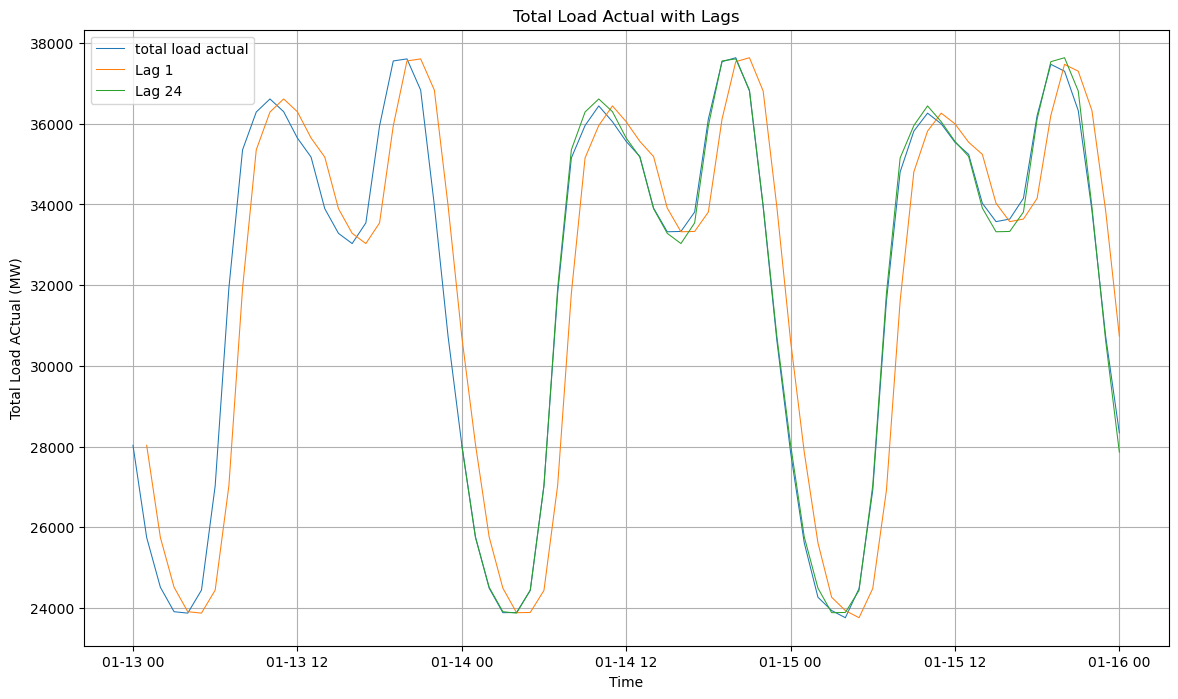

Plot with 2 Days:


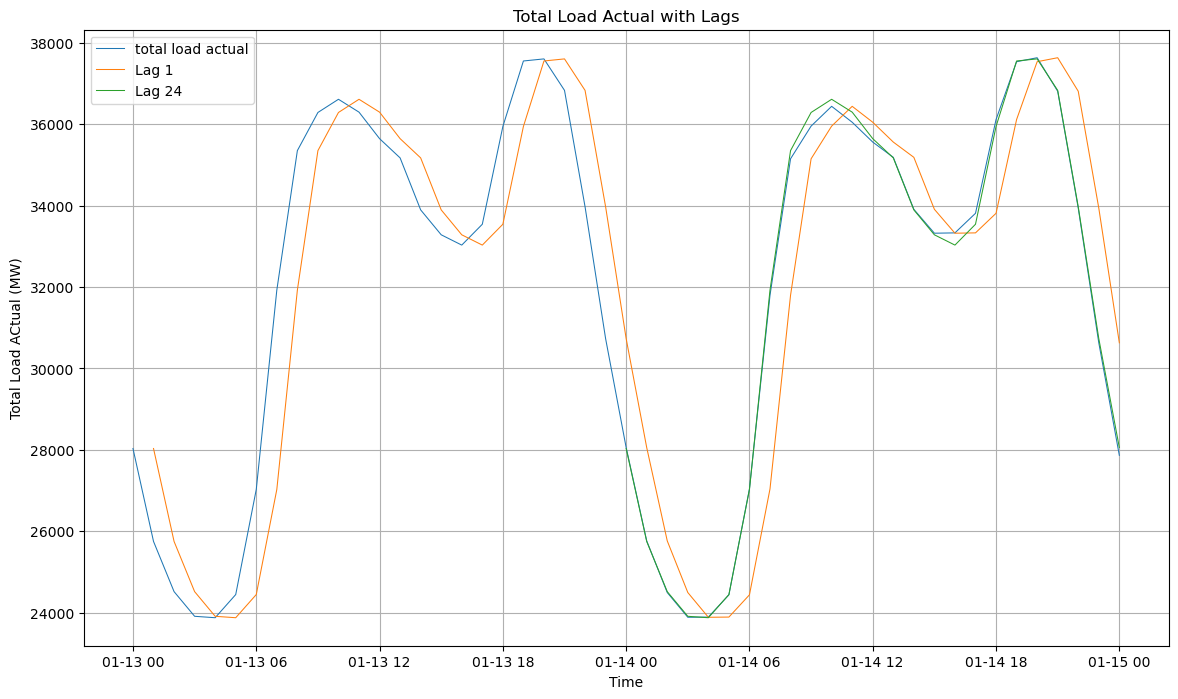

Plot with 1 Days:


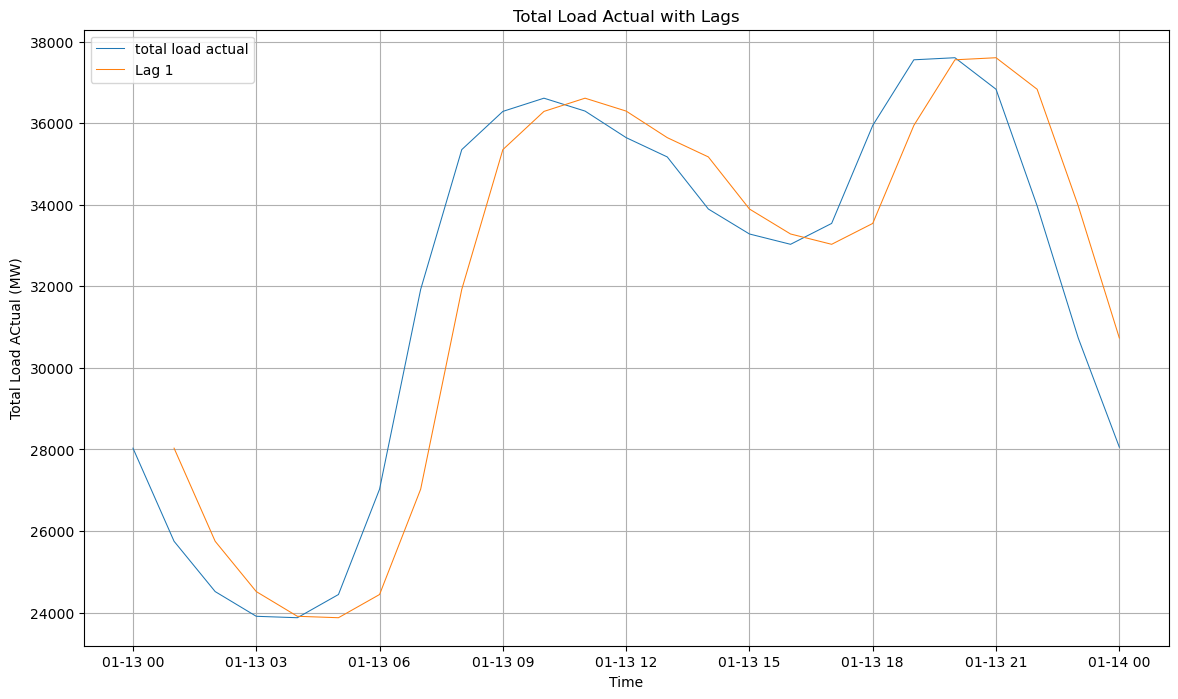

In [21]:
print("Plot with 3 Days:")
plot_lags_n_days(df.iloc[288:], TARGET, [0, 1, 24], days=3)
print("Plot with 2 Days:")
plot_lags_n_days(df.iloc[288:], TARGET, [0, 1, 24], days=2)
print("Plot with 1 Days:")
plot_lags_n_days(df.iloc[288:], TARGET, [0, 1], days=1)

From the line plots above, the target variable clearly exhibits a strong daily seasonal pattern. On an hourly basis, we observe that on two weekdays (2015-01-13 to 2015-01-14), the target variable first peaks at 10 a.m. and again at 7 p.m. The temporary drop in the total load can be explained by the business/work culture in Spain. In Spain, working hours typically run from around 8:30 a.m. or 9 a.m. to around 1:30 p.m., and then from 4:30 p.m. or 5 p.m. to around 8 p.m., with a "siesta" in between. The siesta is a break period when employees relax.

**Source(s):** 
- https://businessculture.org/southern-europe/business-culture-in-spain/work-life-balance-in-spain/

**Note:** Adding features that indicate business hours, siesta times, and other relevant periods could be helpful. Additionally, incorporating three features corresponding to the lags plotted above may provide valuable insights.

**Overall:** This result suggests that missing values in the target variable should be imputed using data from the previous day.

For our analysis, we define the following for our business hour indicator feature:
- 1 ; If hour $\gt$ 8am and hour $\lt$ 2pm or hour $\gt$ 4pm and hour $\lt$ 8pm as during business hours
- 2 ; If hour $\ge$ 2pm and $\le$ 4pm as Siesta
- 0 ; For after business hours

Let's examine how this new feature, in conjunction with time of the week and holiday features, interacts with the target variable.

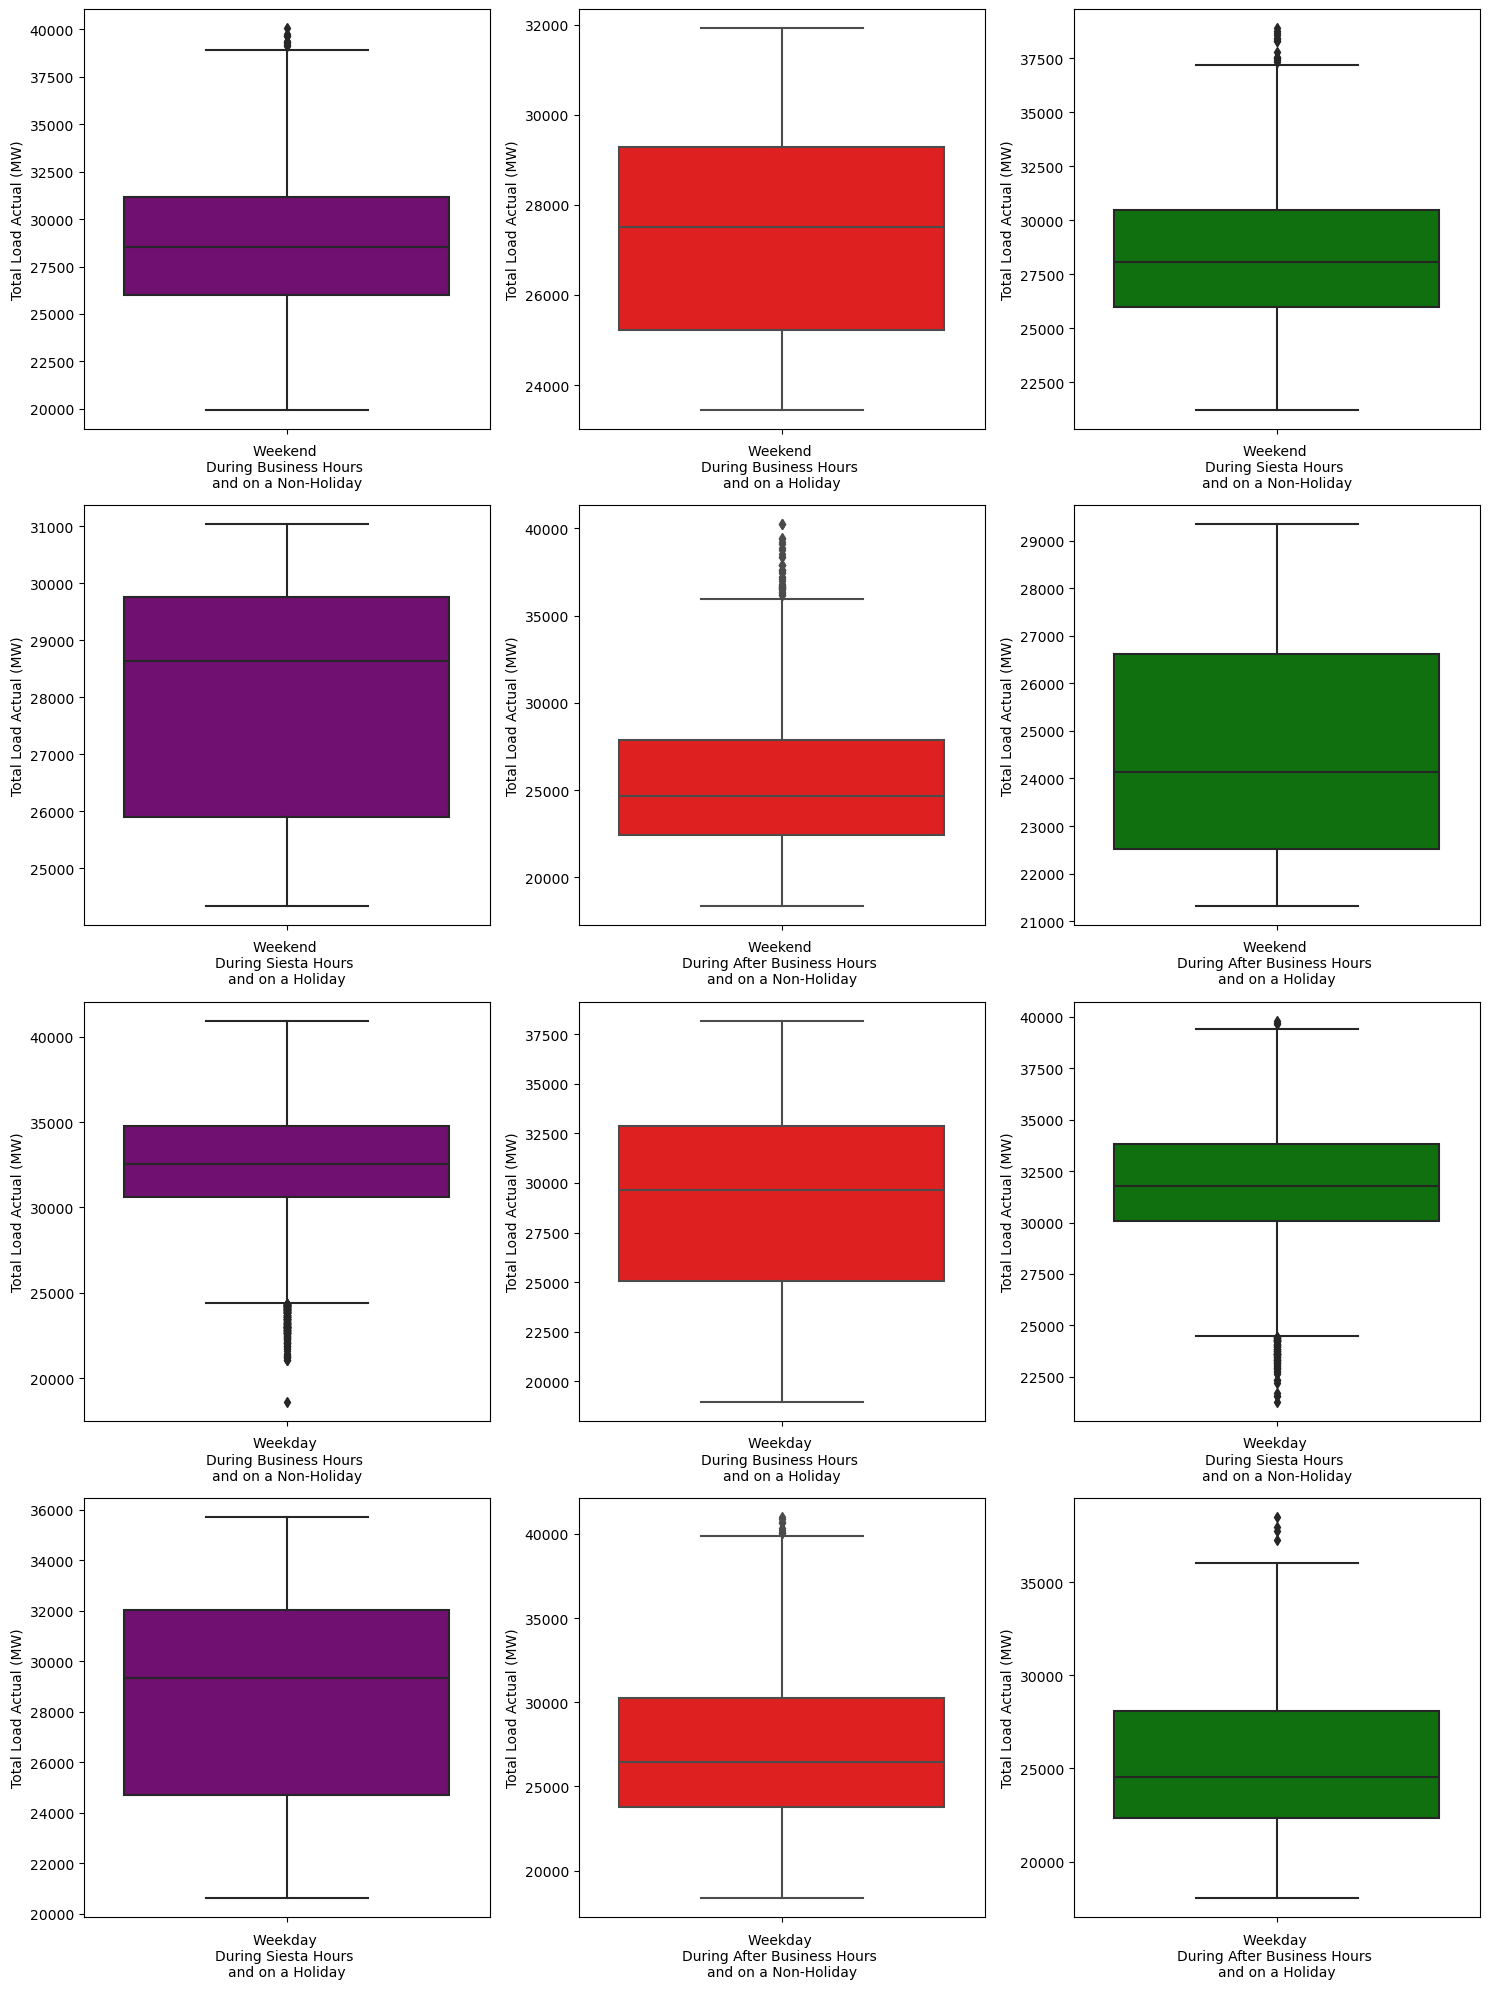

In [22]:
temp = add_business_hours(df.copy())
temp = is_weekday(temp)
temp = is_holidays(temp, temp.index.year.unique())
plot_comp_target(temp, TARGET, "Total Load Actual (MW)")

The boxplots reveal that the target variable, "Total Load Actual", is generally higher and more stable on weekdays compared to weekends, particularly during business hours. On weekdays, demand is more consistent with a narrower range, reflecting steady commercial and industrial activity. In contrast, weekends exhibit lower and more variable demand. During siesta and after-business hours, electricity consumption is lower across both weekdays and weekends, with weekends showing greater variability. Holidays, whether occurring on weekdays or weekends, lead to reduced demand with a wider range of values, indicating less predictable usage patterns compared to non-holidays, where demand remains higher and more consistent. Overall, electricity demand peaks during business hours and non-holidays.

**Notes:**
- Weekends after business hours (non-holidays) also show moderately high demand but with significant variability, suggesting occasional spikes possibly related to residential or entertainment activities.
- Siesta hours, both on weekends and weekdays, demonstrate the most stable demand with low variability, indicating consistently low usage during these times, regardless of whether they are holidays or not.

## 2.1 Imputation

In [23]:
df[f"new_{TARGET}"] = impute_previous_n_days(df[TARGET], days_back = 1)

Some values were unable to impute! - from total load actual


When imputing the target value, there has been an error in imputing some value(s). Lets take a look:

In [24]:
df[df[f"new_{TARGET}"].isna()].index

DatetimeIndex(['2015-05-02 10:00:00+02:00'], dtype='datetime64[ns, CET]', name='time', freq=None)

This makes sense, as the day prior was New Year's Day, a holiday. For simplicity, we will impute the missing value with the value from the previous hour.

In [25]:
df[f"new_{TARGET}"] = custom_ffill_n_hours(df[f"new_{TARGET}"], hours_back = 1)

Now for a sanity check to ensure our target variable has no missing data.

In [26]:
missing_features(df[[f"new_{TARGET}"]])

Empty DataFrame
Columns: [Missing (%), Missing (Count)]
Index: []

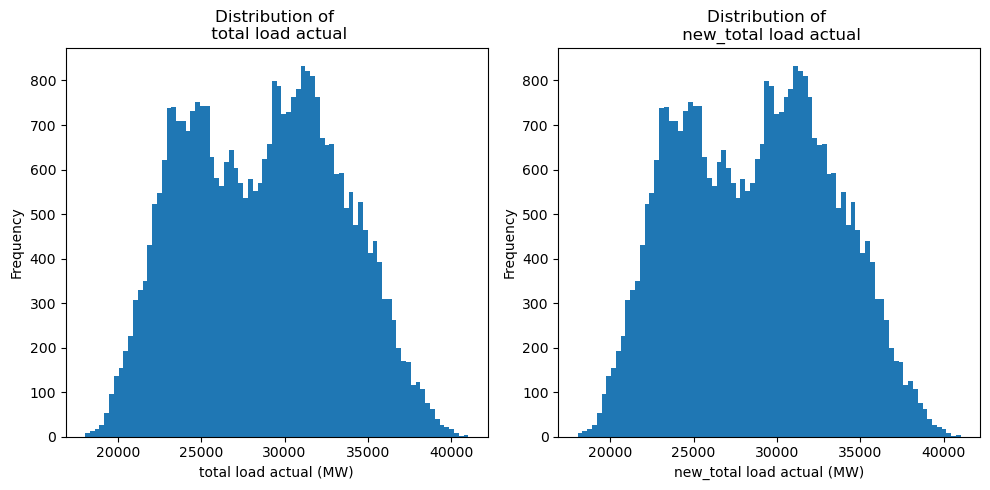

In [27]:
plot_energy_histograms(df, [TARGET, f"new_{TARGET}"], 80)

The most values we imputed for any column was 36. Given that at most 0.1% of the data was imputed, it is not surprising that there is no significant change in the distribution after imputation, as indicated by the results above.

In [28]:
df[TARGET] = df[f"new_{TARGET}"]
df.drop([f"new_{TARGET}"], axis=1, inplace=True)

# Output separate benchmark file
load_benchmark[TARGET] = df[TARGET].copy()
save_file(load_benchmark, "load_benchmark.csv")

File is saved.


## 2.2 Decomposition

Decomposing the target variable provides a better understanding of the underlying patterns driving the data. By isolating the trend, we can observe long-term movements, while seasonality reveals regular, repeating patterns. The residual component captures unexplained variation or noise in the data, which may help in identifying outliers.

Since the time series is quite long, we will plot the first 500 days.

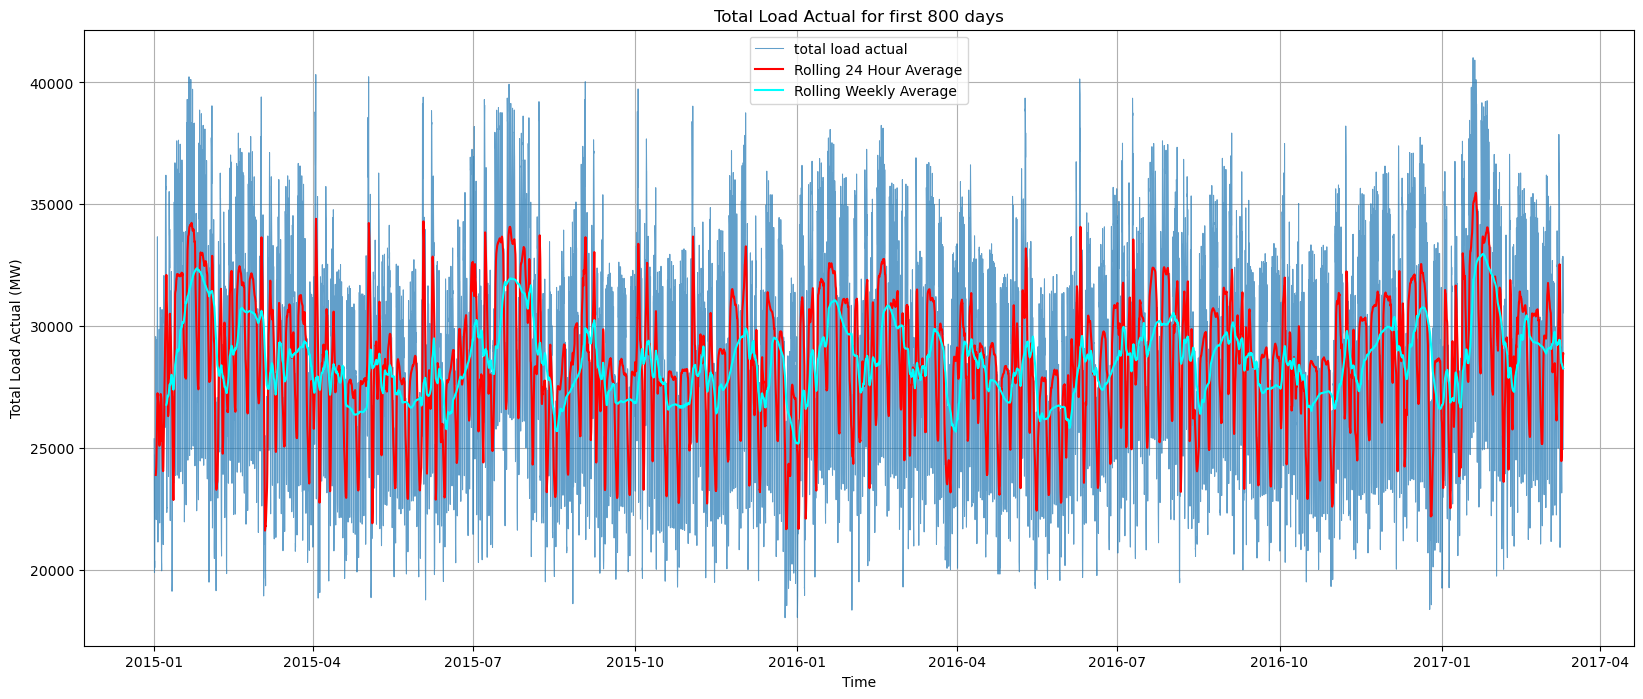

Average Total Load Actual across the entire period:  28697.215320556697
Minimum Total Load Actual across the entire period:  18041.0
Maximum Total Load Actual across the entire period:  41015.0


In [29]:
plot_first_n_days(df, TARGET, days=800)
print("Average Total Load Actual across the entire period: ", np.mean(df[TARGET]))
print("Minimum Total Load Actual across the entire period: ", np.min(df[TARGET]))
print("Maximum Total Load Actual across the entire period: ", np.max(df[TARGET]))

Based on the extended 800-day visualization of our time series, they suggest that an additive decomposition is the most appropriate model. The key justification for this lies in the behavior of the seasonal fluctuations, which remain relatively stable in amplitude over time. As observed in both the daily and weekly rolling averages, the magnitude of seasonal variations does not scale with the overall level of the series. This is a defining characteristic of an additive model, where the seasonal component remains consistent regardless of changes in the trend.

In contrast, if the time series were better suited to a multiplicative model, we would expect to see the seasonal fluctuations grow or shrink in proportion to the level of the trend, particularly when there are significant spikes or dips in the total load. However, neither the short-term noise nor the trend shifts appear to cause such proportional changes in the seasonal patterns, further reinforcing the case for an additive structure.

Moreover, the rolling 24-hour average provides a smooth representation of the underlying patterns in the data, which aligns well with the assumptions of an additive model. It effectively highlights that the seasonal fluctuations remain steady across both higher and lower levels of the overall series.

In summary, the additive decomposition should be preferred here because the seasonal component appears to be independent of the series' magnitude, the trend remains relatively stable, and there is no evidence of the proportional scaling of seasonal fluctuations that would suggest the need for a multiplicative approach.

Given the substantial amount of data, and without smoothing it, let’s decompose the target variable by year.

Seasonal Decomposition of the first 100 days:


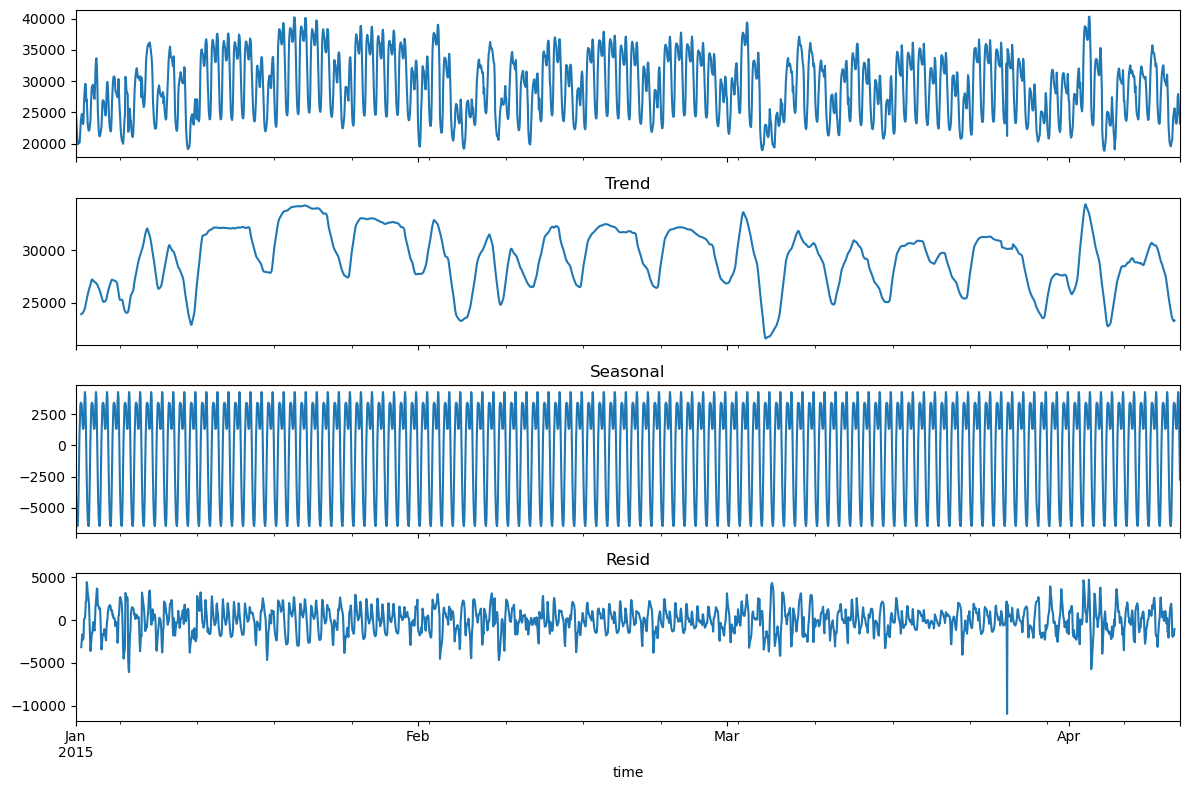

Seasonal Decomposition of Year 2015:


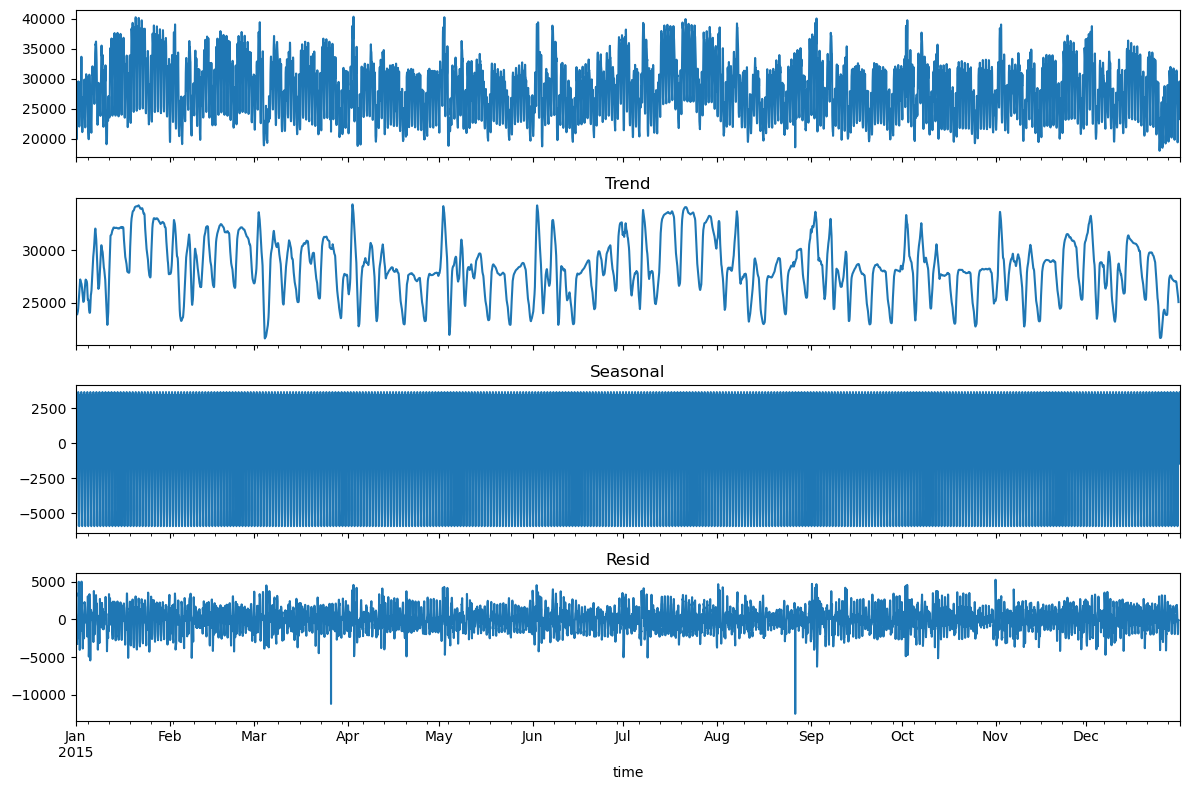

Seasonal Decomposition of Year 2016:


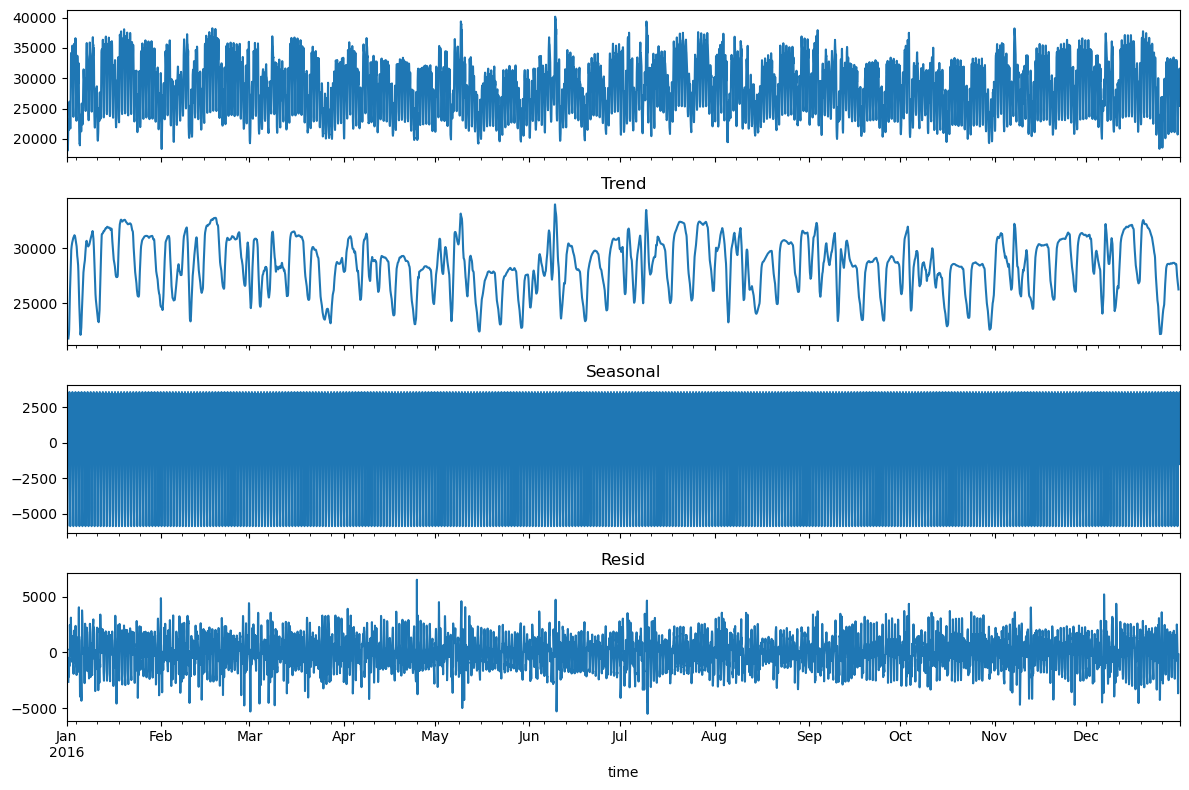

Seasonal Decomposition of Year 2017:


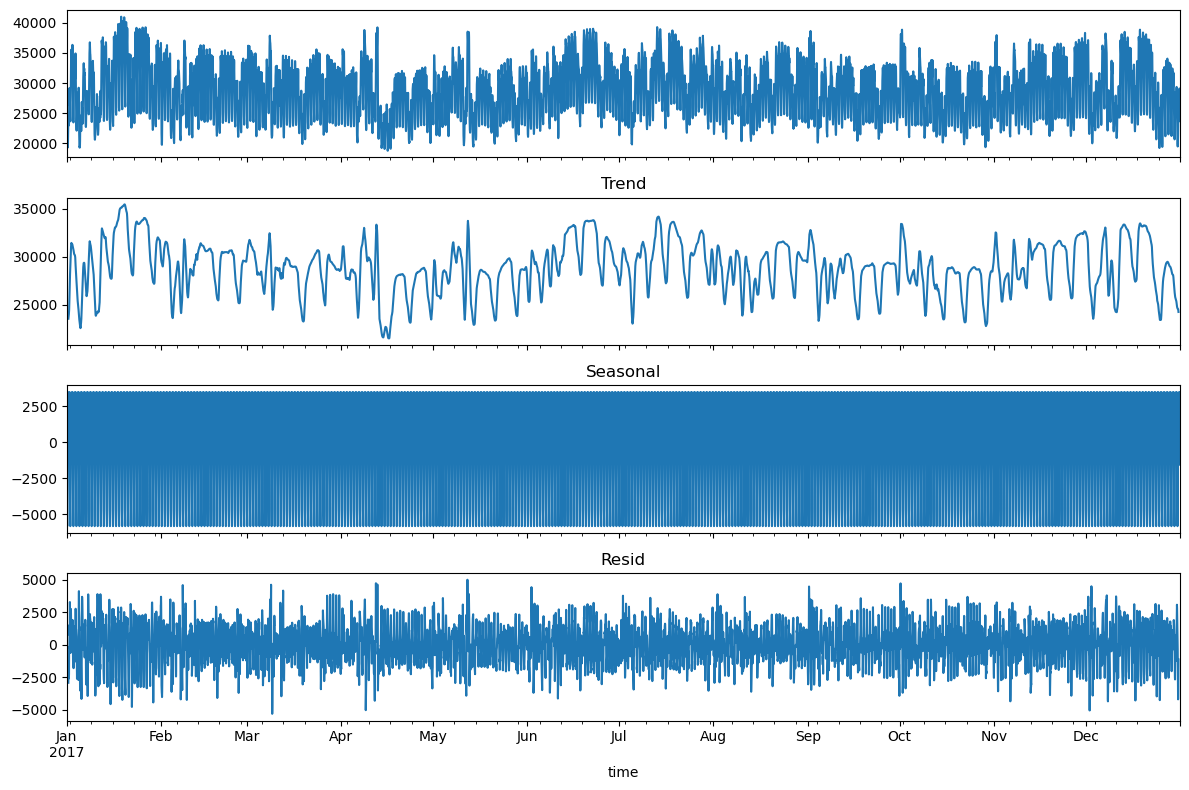

Seasonal Decomposition of Year 2018:


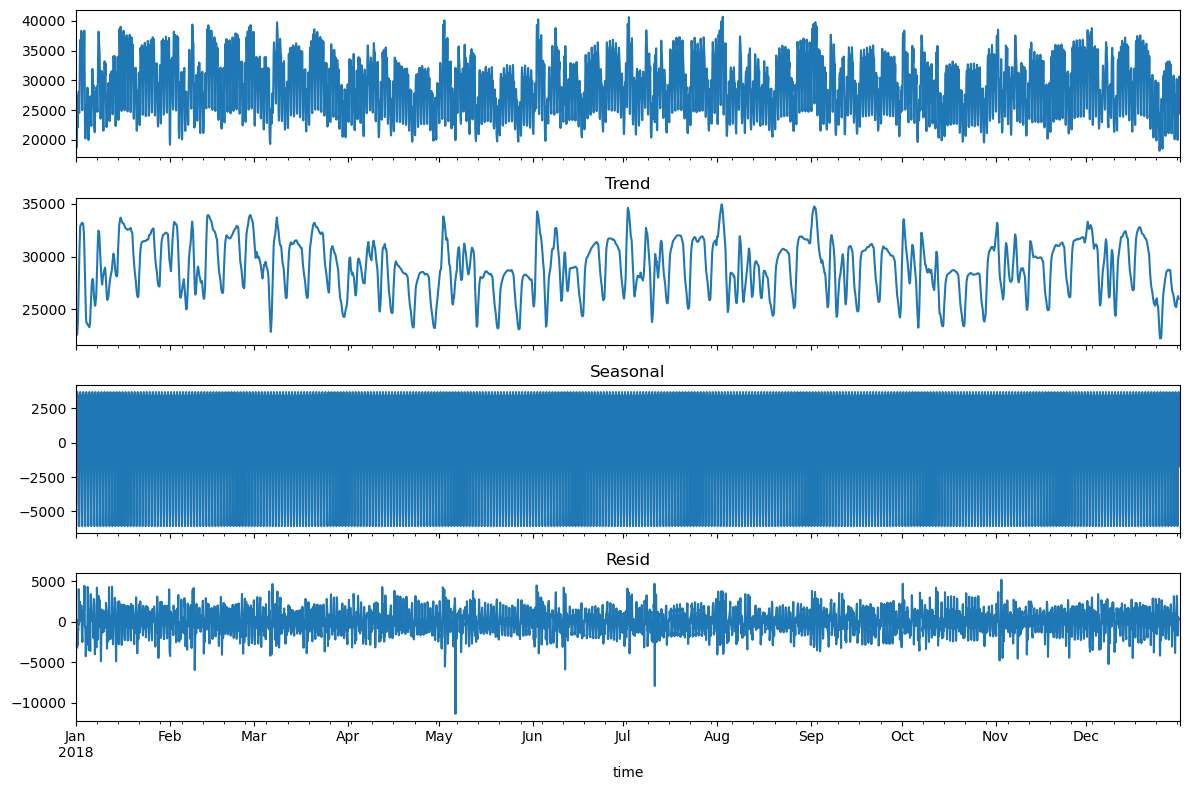

In [30]:
temp = df[TARGET].copy()
df_2015, df_2016, df_2017, df_2018 = temp[temp.index.year == 2015], temp[temp.index.year == 2016], temp[temp.index.year == 2017], temp[temp.index.year == 2018]

first_100_days = temp.loc[temp.index.min():temp.index.min()+pd.Timedelta(days=100)]
print(f"Seasonal Decomposition of the first 100 days:")
plot_decompose_ts(first_100_days, "additive", period=24) 

for i, year_df in enumerate([df_2015, df_2016, df_2017, df_2018]):
    print(f"Seasonal Decomposition of Year {2015+i}:")
    plot_decompose_ts(year_df, "additive", period=24) 

The additive decomposition of the electricity load data from 2015 to 2018 reveals consistent daily and weekly cycles, with stable seasonal patterns across all years. The trend component shows periods of high and low demand, with 2015 experiencing more volatility, while the later years (2016-2018) exhibit smoother trends. The seasonal component maintains a constant amplitude, supporting the use of the additive model. The residuals are generally well-behaved, though each year shows some larger spikes, suggesting potential anomalies. Overall, the additive model fits the data well, capturing stable seasonal patterns and long-term trends.

From the residuals for each year, let's use the interquartile range to identify potential anomalies and compare them to the dates when the total load exceeded 40,000 MW.

In [31]:
decomp = decompose_ts(df[TARGET], "additive")
resid_anom = find_outliers(decomp.resid.dropna()).index
resid_anom

DatetimeIndex(['2015-01-02 00:00:00+01:00', '2015-01-02 01:00:00+01:00',
               '2015-01-02 08:00:00+01:00', '2015-01-02 21:00:00+01:00',
               '2015-01-02 22:00:00+01:00', '2015-01-02 23:00:00+01:00',
               '2015-01-03 08:00:00+01:00', '2015-01-05 07:00:00+01:00',
               '2015-01-05 08:00:00+01:00', '2015-01-05 09:00:00+01:00',
               ...
               '2018-11-08 08:00:00+01:00', '2018-11-11 08:00:00+01:00',
               '2018-11-18 08:00:00+01:00', '2018-11-25 08:00:00+01:00',
               '2018-12-08 07:00:00+01:00', '2018-12-08 08:00:00+01:00',
               '2018-12-08 09:00:00+01:00', '2018-12-16 08:00:00+01:00',
               '2018-12-25 08:00:00+01:00', '2018-12-25 09:00:00+01:00'],
              dtype='datetime64[ns, CET]', name='time', length=334, freq=None)

In [32]:
list(set(tv_extreme) & set(resid_anom))

[Timestamp('2015-09-02 20:00:00+0200', tz='CET'),
 Timestamp('2015-04-02 20:00:00+0200', tz='CET'),
 Timestamp('2015-04-02 19:00:00+0200', tz='CET'),
 Timestamp('2015-05-02 19:00:00+0200', tz='CET')]

Interestingly, out of the 334 potential outliers noted from the residuals of the decomposition, 4 coincide precisely with the hourly periods we flagged where the total load exceeded 40,000 MW.

## 2.3 Stationarity

To develop a better understanding of the nature of the target variable, we will test for stationarity using both the ADF (Augmented Dickey-Fuller) and KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests.

Using both tests provides a more comprehensive check for stationarity. The ADF test is designed to detect non-stationarity due to a unit root, testing whether the series is difference-stationary. It can be configured to include different deterministic components, such as a constant or a trend, depending on the nature of the series. Conversely, the KPSS test evaluates whether a series is stationary around a deterministic trend (i.e., trend-stationary), with the null hypothesis that the series is stationary. By combining these tests, we can detect both types of non-stationarity—unit root and deterministic trend—that might not be fully captured by a single test alone. For this analysis, we will use a significance level of 0.05.

In [33]:
print(is_stationary_adf(df[TARGET]))
print(is_stationary_kpss(df[TARGET]))

Time series is stationary (ADF Test).
The p-value is 0.0.
Time series is not stationary (KPSS Test).
The p-value is 0.01.


From our plot of the target variable over the first 500 days, we observed that the variance increases with the level of the series. To address this, we will apply a log transformation with a shift.

In [34]:
print(is_stationary_adf(np.log(1 + df[TARGET] + np.abs(np.min(df[TARGET])))))
print(is_stationary_kpss(np.log(1 + df[TARGET] + np.abs(np.min(df[TARGET])))))

Time series is stationary (ADF Test).
The p-value is 0.0.
Time series is not stationary (KPSS Test).
The p-value is 0.01.


After applying the log transformation, the target variable remains non-stationary according to the KPSS test. Next, we will apply a first difference transformation to further investigate stationarity.

In [35]:
print(is_stationary_adf(np.log(1 + df[TARGET] + np.abs(np.min(df[TARGET]))).diff(1).dropna()))
print(is_stationary_kpss(np.log(1 + df[TARGET] + np.abs(np.min(df[TARGET]))).diff(1).dropna()))

Time series is stationary (ADF Test).
The p-value is 0.0.
Time series is stationary (KPSS Test).
The p-value is 0.1.


After applying both log and first difference transformations, the target variable is now stationary. Next, let's examine the ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) plots to further analyze the time series.

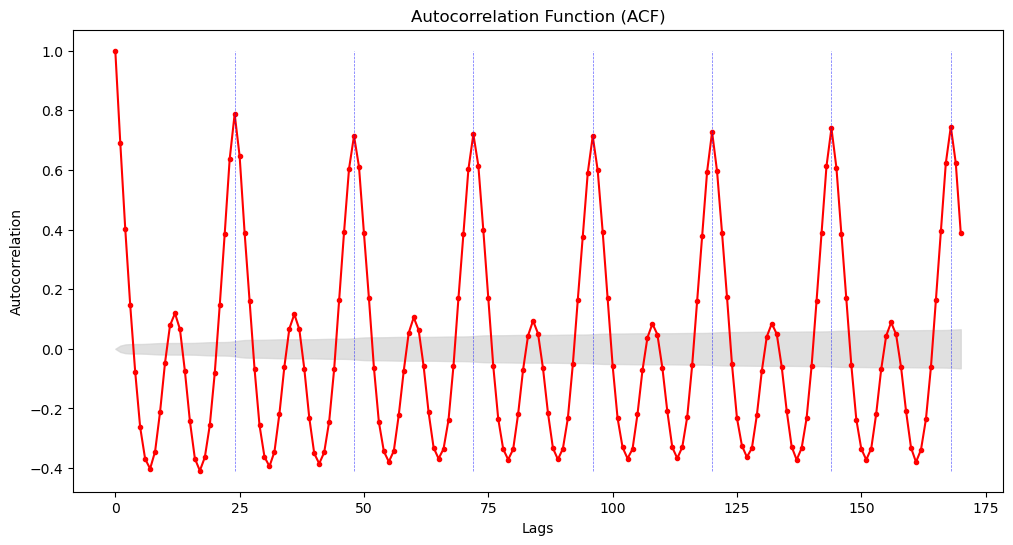

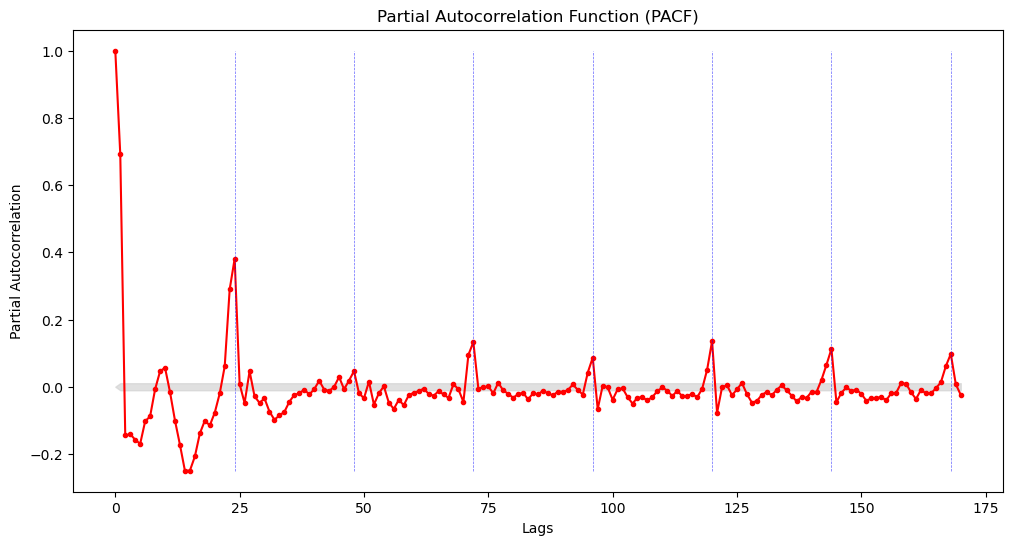

In [36]:
stationary_df = np.log(1 + df[[TARGET]] + np.abs(np.min(df[[TARGET]]))).diff(1).dropna().copy()
plot_acf(stationary_df, TARGET, 170, True)
plot_pacf(stationary_df, TARGET, 170, True)

From the plots above,

The ACF plot reveals a distinct periodic pattern with notable spikes at every 24 lags, indicating a strong seasonal component in the data. The cyclical nature of the ACF suggests the presence of seasonal autocorrelation, rather than a gradual decay typical of a moving average (MA) process. Conversely, the PACF plot displays a sharp cutoff after lag 1, highlighting a significant autoregressive (AR) component at lag 1. Minor oscillations at seasonal lags (around 24, 48, 72, and so forth) in the PACF further reinforce the seasonal nature of the data, with AR effects primarily concentrated at lag 1.

## 2.4 Baseline Model

As we are attempting to create models that could hopefully outperform the total load forecast (ie. our benchmark), let's first use a SARIMA model to assess the extent of improvement offered by the benchmark. This approach will help us understand how well a simpler model performs in comparison and serve as a sanity check to evaluate the reasonableness of the benchmark results, given that we have no knowledge of the methodology used to produce those results.

Based on the ACF and PACF plots, although there is evidence of strong seasonality, we will use an SARIMA(1,0,1)x(1,0,1)$_{24}$ model. Since we have already differenced the data, setting $d=D=0$ helps avoid over-differencing. The PACF and ACF plots suggests $p=P=1$ due to its cutoff at lag 1, while the ACF indicates $q=Q=1$ based on its initial decay.

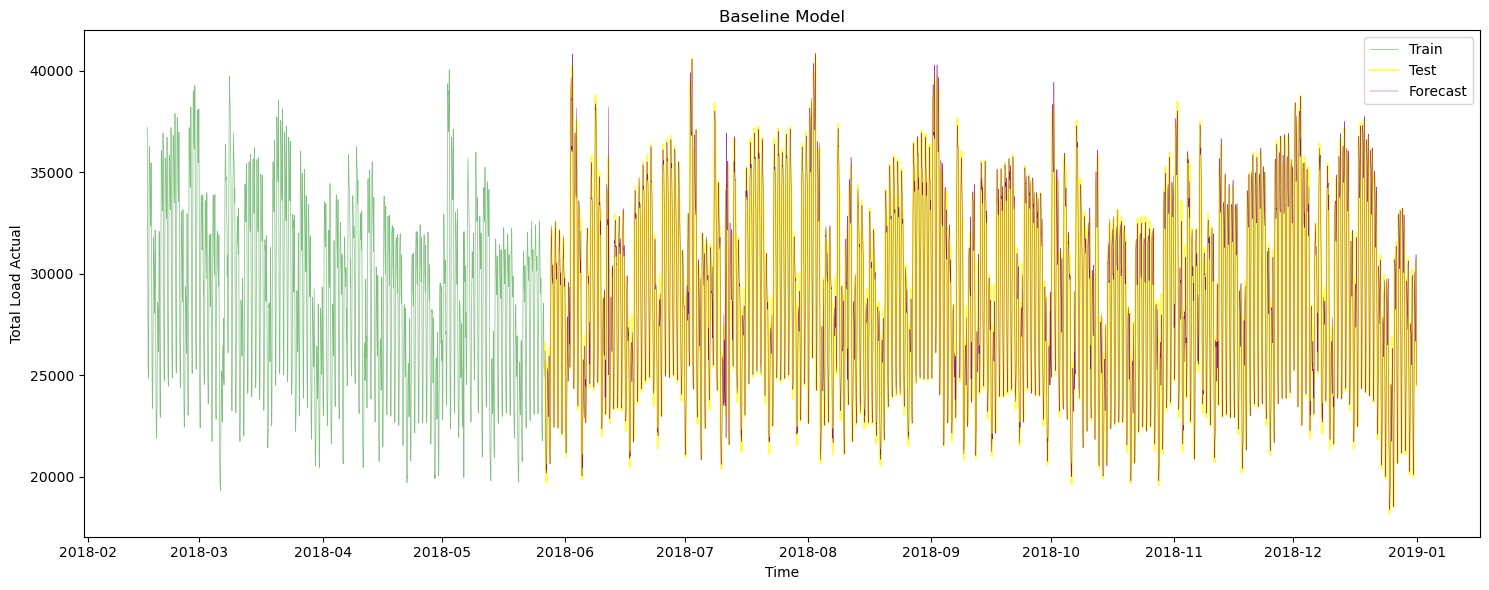

File is saved.
File is saved.


MSE     RMSE      MAE  MAPE
0  768984.585  876.918  600.051  2.13

In [37]:
base_train, base_test = train_test_split(stationary_df[TARGET], df.index, 0.15)
baseline_results, baseline_results_pred = baseline_model(base_train, base_test, (1,0,1), (1,0,1,24), df[TARGET])
save_file(baseline_results_pred, "../Models/Results/baseline_pred.csv")
baseline_results.round(3)

**Benchmark Results (Total Load Forecast):**

We will evaluate the performance of the load benchmark and report the metrics for the same 30% of data used in the testing set for the baseline model.

In [38]:
benchmark_df = pd.read_csv("load_benchmark.csv")
benchmark_df["time"] = pd.to_datetime(benchmark_df["time"], utc=True).dt.tz_convert("CET")
benchmark_df.set_index("time", inplace=True)

index = base_test.index[0]
test_actual, test_benchmark = benchmark_df[TARGET].copy(), benchmark_df[BM].copy()
comp_benchmark_results = evaluate_model(test_actual[test_actual.index >= index], test_benchmark[test_benchmark.index >= index], False)
comp_benchmark_results.round(3)

File is saved.


MSE     RMSE      MAE   MAPE
0  153736.272  392.092  257.757  0.887

From the results above, the overshooting observed in our baseline model (ARIMA(1,0,1)) likely arises because the AR term overemphasizes recent observations, while the MA term overcorrects based on large residuals. Consequently, our ARIMA model shows higher error metrics compared to the benchmark, which better captures the data dynamics. To enhance the model, we could consider seasonal adjustments using SARIMA, given the strong seasonality in the target variable, or optimize parameters through a grid search.

# 3.0 Generation Features

In [39]:
gen_columns = [col for col in df.columns if "generation" in col.lower()] 
print(f"There are {df.loc[df[gen_columns].isna().any(axis=1)][gen_columns].shape[1]} generation columns in this dataset.")

There are 14 generation columns in this dataset.


From the 14 generation features, we observed that each is missing around 17 to 19 hourly periods. Let’s check if there is any overlap in the missing periods.

In [40]:
missing_indexes = [set(df.loc[df[col].isna()].index) for col in gen_columns]
no_gen_data_index = reduce(lambda x, y: x.intersection(y), missing_indexes)
gen_rows_na_index = df.loc[df[gen_columns].isna().any(axis=1)].index
print(f"The number of missing hourly periods in the target variable: {len(set(tv_missing_index))}")
print(f"The number of missing hourly periods from all generation features spread across the dataset: {len(gen_rows_na_index)}")
print(f"The number of missing hourly periods where all generation features have no data: {len(no_gen_data_index)}")


The number of missing hourly periods in the target variable: 36
The number of missing hourly periods from all generation features spread across the dataset: 23
The number of missing hourly periods where all generation features have no data: 17


It appears that the majority of the missing data among the generation features occurs in the same hourly periods.

As there are 14 generation features, let's group them up and analyze them separately for ease. Consider the following groups:
- **Fossil Fuels:** 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil'
- **Renewable Energy:** 'generation biomass', 'generation other renewable', 'generation solar', 'generation wind onshore'
- **Hydroelectric Power:** 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir'
- **Nuclear:** 'generation nuclear'
- **Other Sources:** 'generation other', 'generation waste'


## 3.1 Fossil Fuels

In [41]:
ff_col = [col for col in df.columns if "fossil" in col]
ff_df = df[ff_col].copy()
ff_df = is_weekday(ff_df)
ff_df = is_holidays(ff_df, ff_df.index.year.unique())
ff_df.loc[ff_df[ff_col].isna().any(axis=1)]

generation fossil brown coal/lignite  \
time                                                              
2015-01-05 03:00:00+01:00                                   NaN   
2015-01-05 12:00:00+01:00                                   NaN   
2015-01-05 13:00:00+01:00                                   NaN   
2015-01-05 14:00:00+01:00                                   NaN   
2015-01-05 15:00:00+01:00                                   NaN   
2015-01-05 16:00:00+01:00                                   NaN   
2015-01-05 17:00:00+01:00                                   NaN   
2015-01-19 19:00:00+01:00                                   NaN   
2015-01-19 20:00:00+01:00                                   NaN   
2015-01-27 19:00:00+01:00                                   NaN   
2015-01-28 13:00:00+01:00                                   NaN   
2015-04-16 09:00:00+02:00                                   NaN   
2015-04-23 21:00:00+02:00                                   NaN   
2015-06-15 09:00:00+02:00                                   NaN   
2015-10-02 11:00:00+02:00                                   NaN   
2015-12-02 09:00:00+01:00                                   NaN   
2016-07-09 22:00:00+02:00                                   NaN   
2016-07-12 00:00:00+02:00                                 595.0   
2018-07-11 09:00:00+02:00                                   NaN   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2015-01-05 03:00:00+01:00                    NaN                          NaN   
2015-01-05 12:00:00+01:00                    NaN                          NaN   
2015-01-05 13:00:00+01:00                    NaN                          NaN   
2015-01-05 14:00:00+01:00                    NaN                          NaN   
2015-01-05 15:00:00+01:00                    NaN                          NaN   
2015-01-05 16:00:00+01:00                    NaN                          NaN   
2015-01-05 17:00:00+01:00                    NaN                          NaN   
2015-01-19 19:00:00+01:00                    NaN                          NaN   
2015-01-19 20:00:00+01:00                    NaN                          NaN   
2015-01-27 19:00:00+01:00                    NaN                          NaN   
2015-01-28 13:00:00+01:00                    NaN                          NaN   
2015-04-16 09:00:00+02:00                    NaN                          NaN   
2015-04-23 21:00:00+02:00                    NaN                          NaN   
2015-06-15 09:00:00+02:00                    NaN                          NaN   
2015-10-02 11:00:00+02:00                    NaN                          NaN   
2015-12-02 09:00:00+01:00                    NaN                          NaN   
2016-07-09 22:00:00+02:00                    NaN                          NaN   
2016-07-12 00:00:00+02:00                 5951.0                       6131.0   
2018-07-11 09:00:00+02:00                    NaN                          NaN   

                           generation fossil oil  isWeekday  isHoliday  
time                                                                    
2015-01-05 03:00:00+01:00                    NaN        1.0          0  
2015-01-05 12:00:00+01:00                    NaN        1.0          0  
2015-01-05 13:00:00+01:00                    NaN        1.0          0  
2015-01-05 14:00:00+01:00                    NaN        1.0          0  
2015-01-05 15:00:00+01:00                    NaN        1.0          0  
2015-01-05 16:00:00+01:00                    NaN        1.0          0  
2015-01-05 17:00:00+01:00                    NaN        1.0          0  
2015-01-19 19:00:00+01:00                    NaN        1.0          0  
2015-01-19 20:00:00+01:00                    NaN        1.0          0  
2015-01-27 19:00:00+01:00                    NaN        1.0          0  
2015-01-28 13:00:00+01:00                

**Note:** None of the missing data is on a holiday.

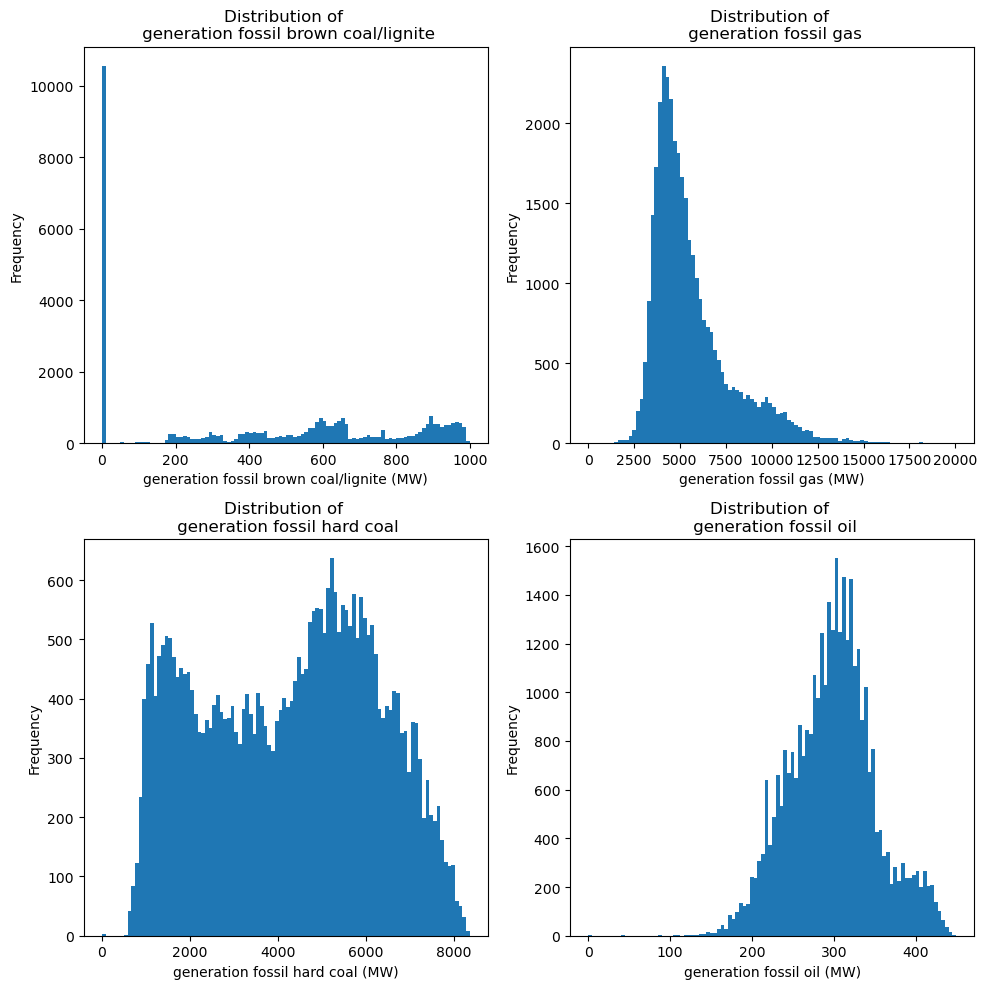

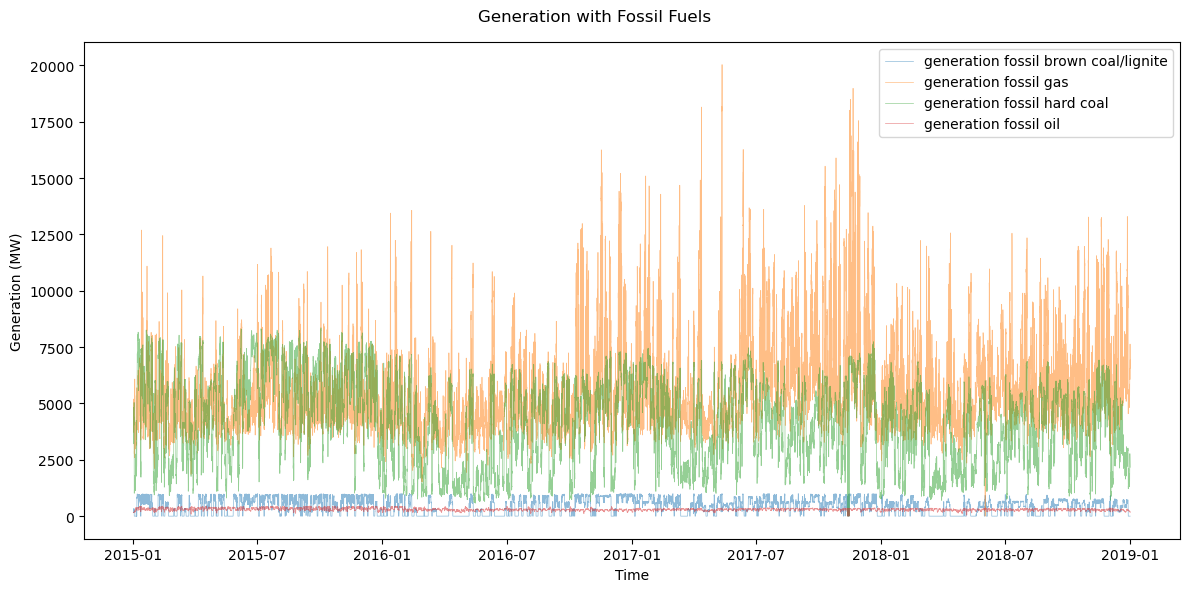

generation fossil brown coal/lignite  generation fossil gas  \
count                          35046.000000           35046.000000   
mean                             448.059208            5622.737488   
std                              354.568590            2201.830478   
min                                0.000000               0.000000   
25%                                0.000000            4126.000000   
50%                              509.000000            4969.000000   
75%                              757.000000            6429.000000   
max                              999.000000           20034.000000   

       generation fossil hard coal  generation fossil oil  
count                 35046.000000           35045.000000  
mean                   4256.065742             298.319789  
std                    1961.601013              52.520673  
min                       0.000000               0.000000  
25%                    2527.000000             263.000000  
50%                    4474.000000             300.000000  
75%                    5838.750000             330.000000  
max                    8359.000000             449.000000

In [42]:
plot_energy_histograms(ff_df, ff_col)
plot_linegraphs(ff_df, ff_col, "Time", "Generation (MW)", "Generation with Fossil Fuels")
ff_df[ff_col].describe()

From the outputs above:

**Generation using fossil hard coal** has a bimodal distribution. The line plot reveals a decrease from the end of 2015 to mid-2016, which corresponds to an increase in variability in generation using fossil gas. This suggests a shift in the preference for fossil fuels used in generation. Research indicates that at the end of 2015 and into 2016, fossil gas (natural gas) prices were relatively low, making it a more economical choice for power generation.

**Generation using fossil gas** also displays a right-skewed distribution. However, the peak suggests that this fossil fuel is likely the most reliable. Research shows that fossil gas is often cheaper, has lower carbon emissions, and is flexible in power generation (i.e., it can ramp up and down quickly). These factors explain the high variability and skewness of the distribution. Additionally, there has been significant investment in building infrastructure to support this generation type.

**Generation using fossil oil** is the lowest among the fuels, which could be attributed to the fact that oil is typically more expensive than gas and coal for electricity generation. Oil prices are also quite volatile, making it less economically viable for power generation. Furthermore, tighter regulations and the higher emissions of pollutants from fossil oil could explain its low usage. The histogram shows that, unlike fossil gas, fossil oil is not used to meet additional demand.

**Generation with fossil brown coal** shows an abundance of zeros in its histogram. This may be due to either misentries or a preference for using other fuels for electricity generation. Research indicates that fossil brown coal/lignite has lower energy content compared to other types of coal and produces higher carbon dioxide emissions per unit of electricity generated. The line plot shows that for a majority of the time series, generation with brown coal is zero when generation using both gas and hard coal declines, and increases when both gas and hard coal increase. This suggests that electricity generation with fossil brown coal is given very low priority.

**Note:** It appears that energy generation with fossil gas displays higher fluctuations (increasing variance) over time.

**Sources:**
- https://www.eia.gov/todayinenergy/detail.php?id=25392#:~:text=In%20EIA%27s%20forecast%2C%20natural%20gas,with%20hydropower%27s%20share%20at%206%25.
- https://www.eia.gov/todayinenergy/detail.php?id=31672#:~:text=Competition%20between%20coal%20and%20natural%20gas%20affects%20power%20markets,-Source%3A%20U.S.%20Energy&text=In%202016%2C%20natural%20gas%20provided,an%20annual%20basis%20in%202016.
- https://www.iea.org/reports/the-role-of-gas-in-todays-energy-transitions
- https://www.eia.gov/energyexplained/natural-gas/ 
- https://www.eia.gov/energyexplained/oil-and-petroleum-products/use-of-oil.php
- https://www.eia.gov/todayinenergy/detail.php?id=31232
- https://www.eia.gov/energyexplained/coal/prices-and-outlook.php
- https://www.eea.europa.eu/en/analysis/indicators/emissions-and-energy-use-in 
- https://www.volker-quaschning.de/datserv/CO2-spez/index_e.php

As none of the missing data from any of these four features are on a holiday, let's consider the hourly boxplots and ACF plots across the entire timeseries to better understand the features.

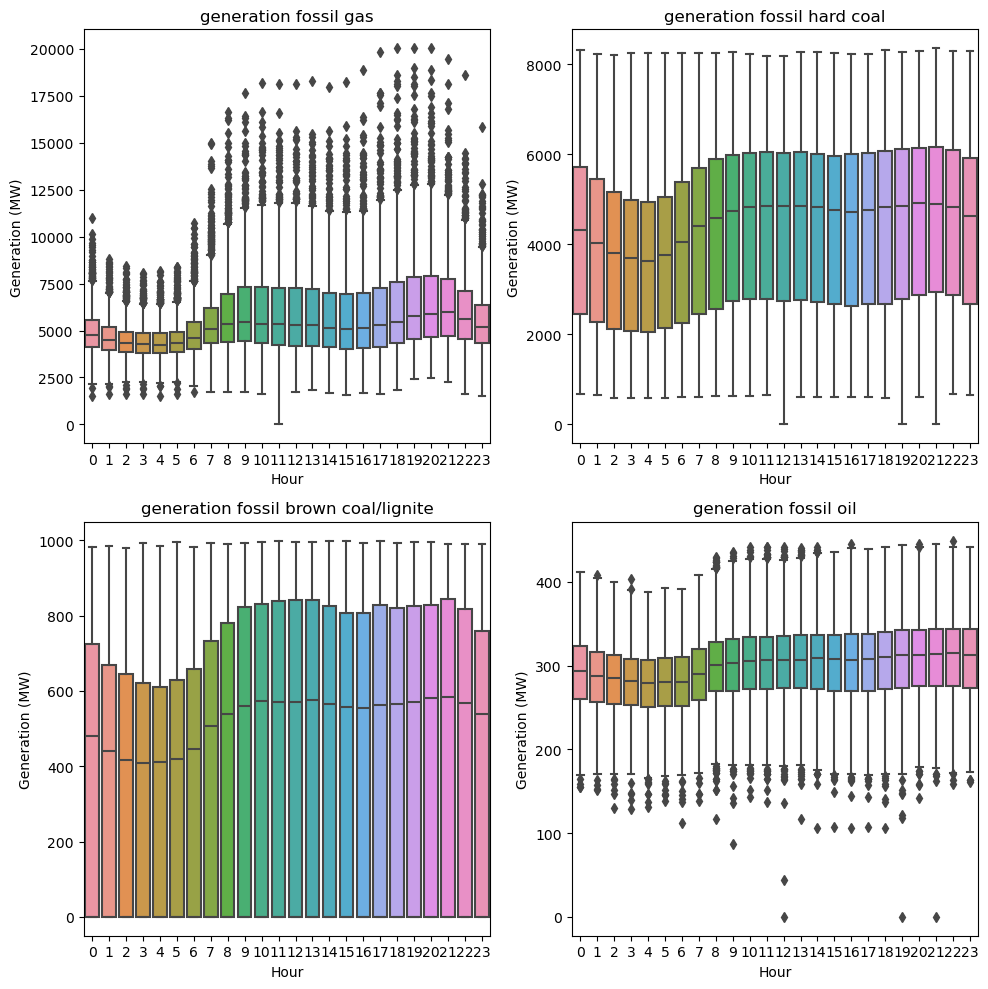

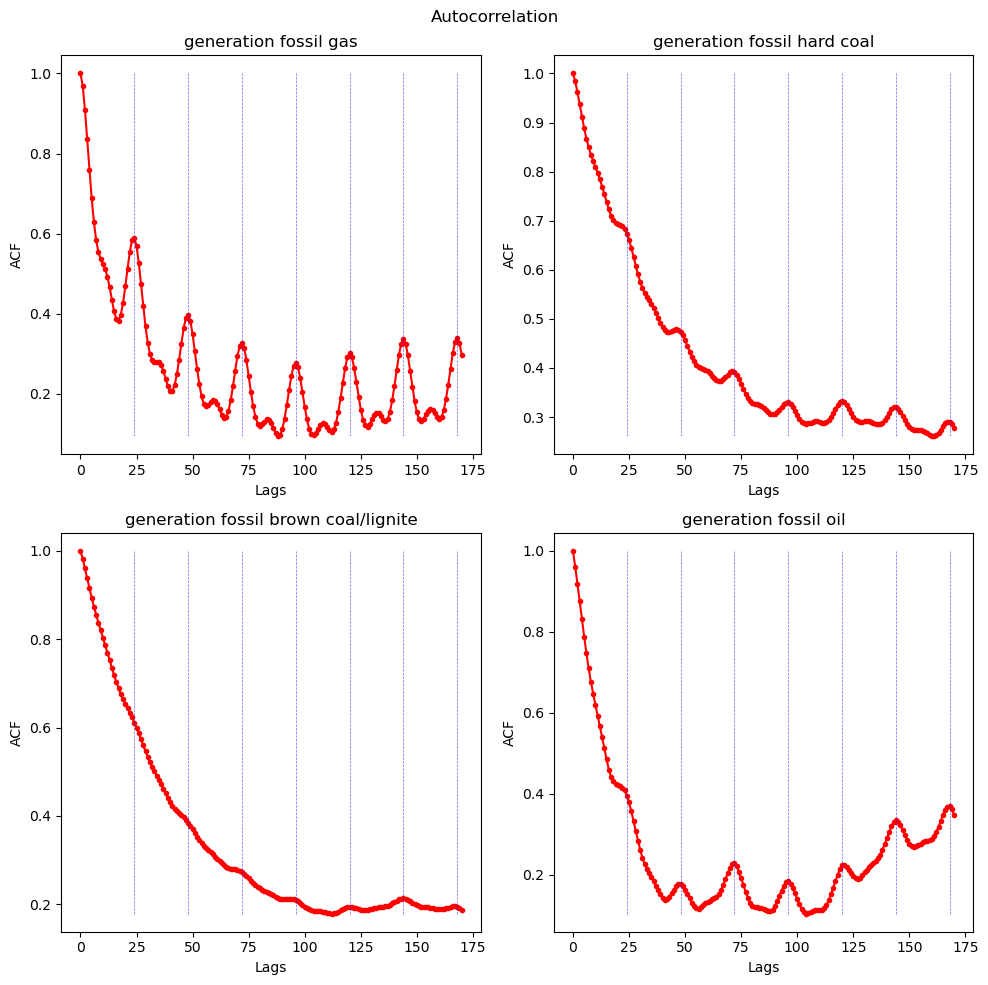

In [43]:
ff_df['hour'] = ff_df.index.hour
ff_col = ['generation fossil gas','generation fossil hard coal','generation fossil brown coal/lignite','generation fossil oil'] # rearrange descending order
plot_gen_boxplots(ff_df[ff_df["isHoliday"]==0], ff_col)
plot_acf_pacf_group(ff_df[ff_df["isHoliday"]==0], ff_col)

**For Generation Fossil Gas**

The boxplot indicates higher values during peak hours, specifically between around 11 a.m. and 7 p.m. This suggests increased energy demand during these times. The ACF plot reveals clear daily cyclical patterns, similar to those observed in the target variable. Given the faster ramp-up times and the presence of outliers, it is not surprising to see such variability. Considering adding a feature that indicates whether a day is a holiday could be valuable for improving the model. Based on these observations, it is advisable to impute missing values from the target variable using data from the previous day.

**For Generation Fossil Hard Coal**

The boxplot for fossil hard coal shows a moderate daily pattern, with values rising during daylight hours and falling at night. The ACF plot demonstrates autocorrelation with a gradual decline, indicating some level of seasonality. To address missing values, it is recommended to use data from the previous day for imputation.

**For Generation Fossil Brown Coal/Lignite**

The boxplot indicates a steady trend with an increase in generation during the early mornings. However, the ACF plot shows weak to no signs of seasonality, suggesting minimal cyclical patterns. Given this lack of significant seasonal variation, a forward-fill imputation method is recommended for handling missing values.

**For Generation Fossil Oil**
The boxplot for fossil oil shows the least variation and appears relatively stable across all hours. The ACF plot reveals noticeable cyclical patterns, suggesting some level of periodic behavior. For imputing missing values, it is advisable to use a time-of-day context, such as imputing missing values at 12 p.m. with the average of the last 12 p.m. values from the past three days.

**Overall**

The boxplots for fossil gas and fossil oil indicate that outliers are more prevalent between 8 a.m. and 8 p.m., aligning with typical working hours and siesta periods. This observation highlights the importance of considering daily patterns and potential outlier influences in the modeling process.

### 3.1.1 Imputation

In [44]:
col_dict = {'generation fossil gas':1, 'generation fossil hard coal':1}
for col in list(col_dict.keys()):
    ff_df[col] = impute_previous_n_days(ff_df.copy()[col], col_dict[col])   

col_dict_mean = {'generation fossil oil':3}
for col in list(col_dict_mean.keys()):
    ff_df[col] = impute_stat_n_days(ff_df.copy()[col], col_dict_mean[col], np.mean)

col_dict = {'generation fossil brown coal/lignite':1}
for col in list(col_dict.keys()):
    ff_df[col] = custom_ffill_n_hours(ff_df.copy()[col], col_dict[col])

missing_features(ff_df)

Empty DataFrame
Columns: [Missing (%), Missing (Count)]
Index: []

All missing data in the four fossil fuel generation features are handled!

In [45]:
for col in ff_col:
    df[col] = ff_df[col]

## 3.2 Renewable Energy

In [46]:
re_col = ['generation biomass', 'generation other renewable', 'generation solar', 'generation wind onshore']
re_df = df[re_col].copy()
re_df = is_weekday(re_df)
re_df = is_holidays(re_df, re_df.index.year.unique())
re_df.loc[re_df[re_col].isna().any(axis=1)]

generation biomass  generation other renewable  \
time                                                                        
2015-01-05 03:00:00+01:00                 NaN                         NaN   
2015-01-05 12:00:00+01:00                 NaN                         NaN   
2015-01-05 13:00:00+01:00                 NaN                         NaN   
2015-01-05 14:00:00+01:00                 NaN                         NaN   
2015-01-05 15:00:00+01:00                 NaN                         NaN   
2015-01-05 16:00:00+01:00                 NaN                         NaN   
2015-01-05 17:00:00+01:00                 NaN                         NaN   
2015-01-19 19:00:00+01:00                 NaN                         NaN   
2015-01-19 20:00:00+01:00                 NaN                         NaN   
2015-01-27 19:00:00+01:00                 NaN                         NaN   
2015-01-28 13:00:00+01:00                 NaN                         NaN   
2015-04-16 09:00:00+02:00                 NaN                         NaN   
2015-04-23 21:00:00+02:00                 NaN                         NaN   
2015-06-15 09:00:00+02:00                 NaN                         NaN   
2015-10-02 11:00:00+02:00                 NaN                         NaN   
2015-12-02 09:00:00+01:00                 NaN                         NaN   
2016-07-09 22:00:00+02:00                 NaN                         NaN   
2016-11-23 04:00:00+01:00                 NaN                        85.0   
2018-07-11 09:00:00+02:00                 NaN                         NaN   

                           generation solar  generation wind onshore  \
time                                                                   
2015-01-05 03:00:00+01:00               NaN                      NaN   
2015-01-05 12:00:00+01:00               NaN                      NaN   
2015-01-05 13:00:00+01:00               NaN                      NaN   
2015-01-05 14:00:00+01:00               NaN                      NaN   
2015-01-05 15:00:00+01:00               NaN                      NaN   
2015-01-05 16:00:00+01:00               NaN                      NaN   
2015-01-05 17:00:00+01:00               NaN                      NaN   
2015-01-19 19:00:00+01:00               NaN                      NaN   
2015-01-19 20:00:00+01:00               NaN                      NaN   
2015-01-27 19:00:00+01:00               NaN                      NaN   
2015-01-28 13:00:00+01:00               NaN                      NaN   
2015-04-16 09:00:00+02:00               NaN                      NaN   
2015-04-23 21:00:00+02:00               NaN                      NaN   
2015-06-15 09:00:00+02:00               NaN                      NaN   
2015-10-02 11:00:00+02:00               NaN                      NaN   
2015-12-02 09:00:00+01:00               NaN                      NaN   
2016-07-09 22:00:00+02:00               NaN                      NaN   
2016-11-23 04:00:00+01:00              15.0                   4598.0   
2018-07-11 09:00:00+02:00               NaN                      NaN   

                           isWeekday  isHoliday  
time                                             
2015-01-05 03:00:00+01:00        1.0          0  
2015-01-05 12:00:00+01:00        1.0          0  
2015-01-05 13:00:00+01:00        1.0          0  
2015-01-05 14:00:00+01:00        1.0          0  
2015-01-05 15:00:00+01:00        1.0          0  
2015-01-05 16:00:00+01:00        1.0          0  
2015-01-05 17:00:00+01:00        1.0          0  
2015-01-19 19:00:00+01:00        1.0          0  
2015-01-19 20:00:00+01:00        1.0          0  
2015-01-27 19:00:00+01:00        1.0          0  
2015-01-28 13:00:00+01:00        1.0          0  
2015-04-16 09:00:00+02:00        1.0          0  
2015-04-23 21:00:00+02:00        1.0          0  
2015-06-15 09:00:00+02:00        1.0          0  
2015-10-02 11:00:00+02:00        1.0          0  
2015-12-02 09:00:00+01:00        1.0          

**Note:** None of the missing data is on a holiday.

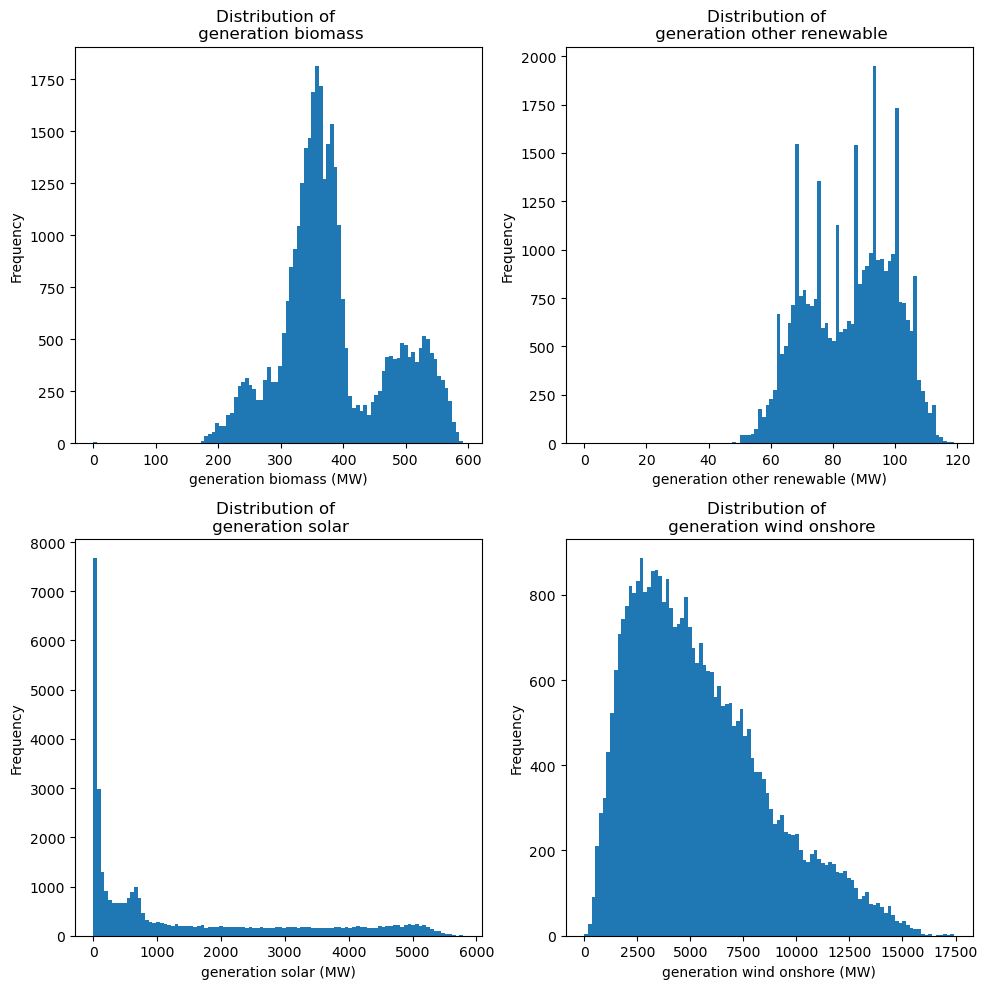

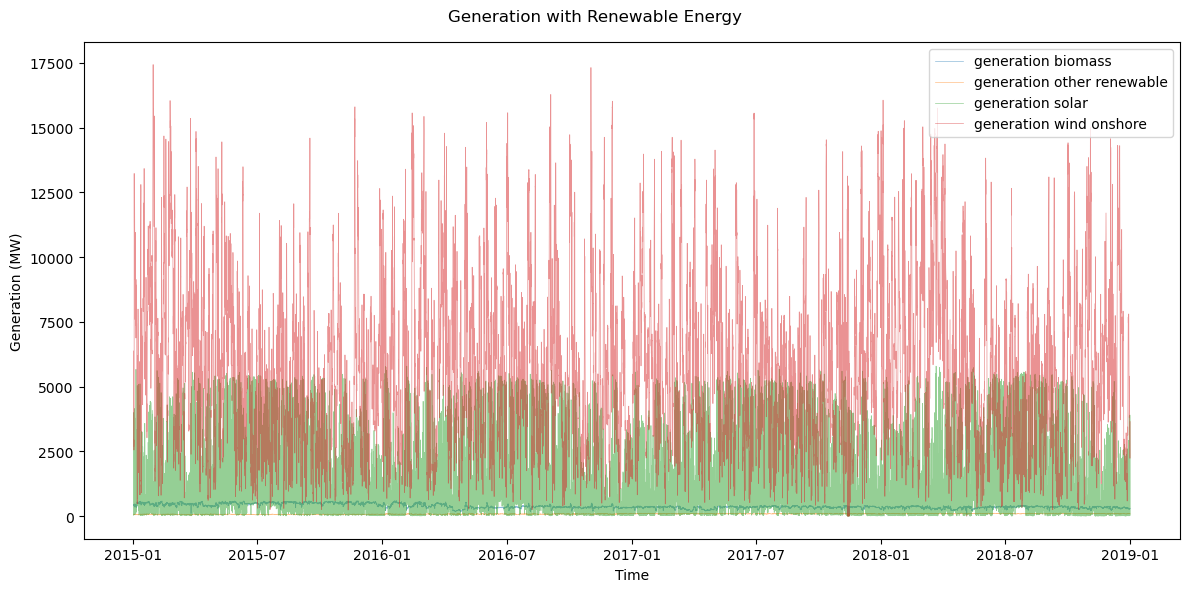

generation biomass  generation other renewable  generation solar  \
count        35045.000000                35046.000000      35046.000000   
mean           383.513540                   85.639702       1432.665925   
std             85.353943                   14.077554       1680.119887   
min              0.000000                    0.000000          0.000000   
25%            333.000000                   73.000000         71.000000   
50%            367.000000                   88.000000        616.000000   
75%            433.000000                   97.000000       2578.000000   
max            592.000000                  119.000000       5792.000000   

       generation wind onshore  
count             35046.000000  
mean               5464.479769  
std                3213.691587  
min                   0.000000  
25%                2933.000000  
50%                4849.000000  
75%                7398.000000  
max               17436.000000

In [47]:
plot_energy_histograms(re_df, re_col)
plot_linegraphs(re_df, re_col, "Time", "Generation (MW)", "Generation with Renewable Energy")
re_df[re_col].describe()

From the outputs above:

The distribution of **generation from wind onshore** is right-skewed, which reflects the nature of wind speeds. This skewness implies a higher frequency of lower wind speeds and fewer instances of very high wind speeds, directly affecting wind onshore generation. The distribution also indicates that wind onshore can generate electricity continuously as long as there is wind, resulting in consistent production throughout the day and night. The line plot further shows that wind onshore generation significantly outpaces other renewable methods. This dominance is attributed to the continuous operation of wind turbines and Spain's substantial investments in wind energy over the years, making it one of the leading sources of renewable energy in the country.

The distribution of **solar generation** data shows signs of either outliers or a considerable number of misentries. This is reasonable, considering that solar energy cannot be generated at night or during adverse weather conditions such as heavy cloud cover, rain, or snow. The spread of the data may also be influenced by the varying intensity of sunlight throughout the day. Similar to wind onshore, the high variation in solar generation can be attributed to its dependence on natural conditions.

**Generation from biomass** relies on organic materials such as agricultural residues, forestry by-products, and waste, which can be limited by geographic and climatic factors. While Spain's climate and geography provide significant resources for solar and wind energy, biomass generation remains a relatively insignificant source of electricity. The data reflects this limited contribution, underscoring the dominance of solar and wind resources in Spain's energy mix.

**Sources:**
- https://pubs.aip.org/aip/jrse/article/13/2/023303/926742/Estimation-of-Weibull-parameters-for-wind-energy
- https://aeeolica.org/en/about-wind-energy/wind-energy-in-spain/
- https://www.eia.gov/energyexplained/biomass/#:~:text=Biomass—renewable%20energy%20from%20plants%20and%20animals&text=Biomass%20can%20be%20burned%20directly,consumption%20until%20the%20mid-1800s.
- https://medium.com/@GSPIAe_eBlog/should-spain-be-europes-solar-powerhouse-857af55f4bd9

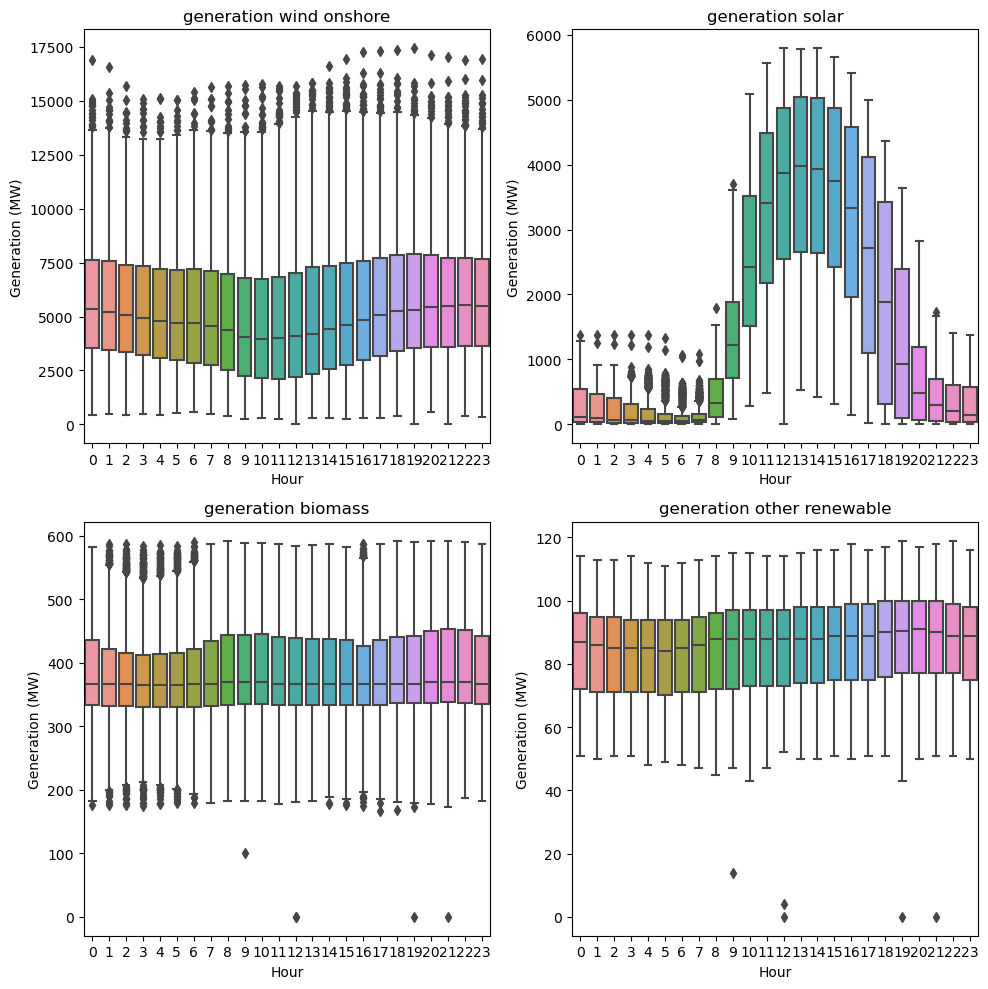

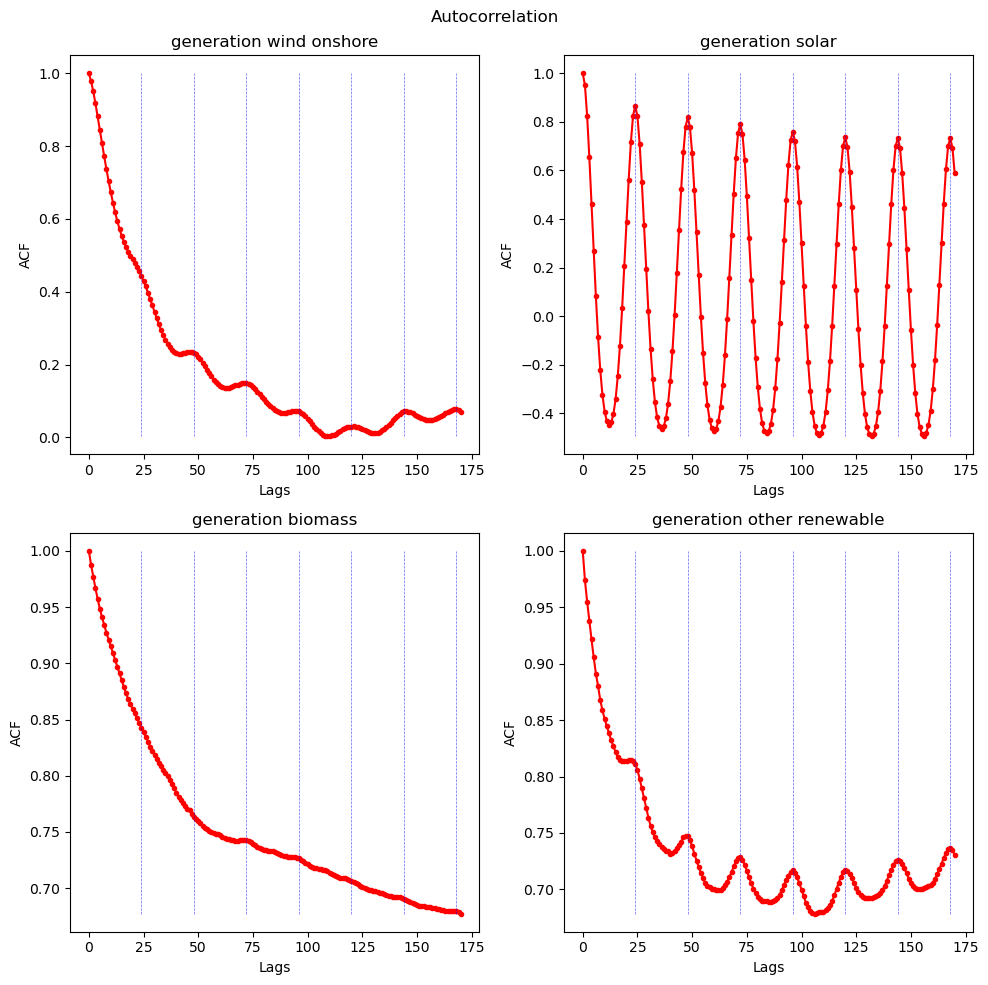

In [48]:
re_df['hour'] = re_df.index.hour
re_col = ['generation wind onshore', 'generation solar', 'generation biomass', 'generation other renewable']
plot_gen_boxplots(re_df[re_df["isHoliday"]==0], re_col)
plot_acf_pacf_group(re_df[re_df["isHoliday"]==0], re_col)

**For Generation Wind Onshore**

The boxplot reveals that the distribution of wind onshore generation is relatively stable throughout the day, with a slight dip around midday. Outliers beyond the maximum whiskers are expected due to the dependency on natural air movement. The ACF plot shows a strong autocorrelation that gradually decreases, indicating the presence of a trend component with moderate seasonality. Based on these observations, it is recommended to impute missing values in the target variable using data from the previous day.

**For Generation Solar**

The boxplot for solar generation displays a clear daily cycle, with no generation at night and peaks around midday. The variability is higher during peak hours due to dependence on weather conditions. Outliers observed early in the morning might occur during the spring season when daylight begins earlier. The ACF plot confirms strong daily seasonality, with clear peaks every 24 hours. Consequently, it is advisable to impute missing values from the target variable using data from the previous day.

**For Generation Other Renewable**

The boxplot for other renewable energy sources shows that the data is fairly stable throughout the day, with a few extreme outliers during specific hours. The variability remains relatively constant, indicating a consistent generation pattern. The ACF plot suggests a gradual decline in autocorrelation with slight undulating patterns, pointing to minor seasonality or cyclical trends. Based on these findings, imputing values using a time-of-day context, such as the average of the last 12 p.m. values from the past three days, would be appropriate.

**For Generation Biomass**

The boxplot indicates slight variability in biomass generation, with a minor dip around midday, suggesting a stable but slightly varying pattern. There are outliers at both low and high extremes. The ACF plot shows a gradual decline in autocorrelation, suggesting a weak trend but a consistent pattern over time. For handling missing values, it is recommended to use a time-of-day context, such as imputing missing 12 p.m. values using the median of the last 12 p.m. values from the past three days.

**Overall**

Both wind and solar generation are influenced by seasonality. Incorporating a feature that indicates the season could enhance the model’s performance by accounting for these seasonal effects.

### 3.2.1 Imputation

In [49]:
col_dict = {'generation wind onshore':1, 'generation solar':1}
for col in list(col_dict.keys()):
    re_df[col] = impute_previous_n_days(re_df.copy()[col], col_dict[col])   

col_dict_median = {'generation biomass':3}
for col in list(col_dict_median.keys()):
    re_df[col] = impute_stat_n_days(re_df.copy()[col], col_dict_median[col], np.median)

col_dict_mean = {'generation other renewable': 3}
for col in list(col_dict_mean.keys()):
    re_df[col] = impute_stat_n_days(re_df.copy()[col], col_dict_mean[col], np.mean)

missing_features(re_df)

Empty DataFrame
Columns: [Missing (%), Missing (Count)]
Index: []

All missing data in the four renewable energy generation features are handled!

In [50]:
for col in re_col:
    df[col] = re_df[col]

## 3.3 Hydroelectric Power

In [51]:
he_col = [col for col in df.columns if "hydro" in col]
he_df = df[he_col].copy()
he_df = is_weekday(he_df)
he_df = is_holidays(he_df, he_df.index.year.unique())
he_df.loc[he_df[he_col].isna().any(axis=1)]

generation hydro pumped storage consumption  \
time                                                                     
2015-01-05 03:00:00+01:00                                          NaN   
2015-01-05 12:00:00+01:00                                          NaN   
2015-01-05 13:00:00+01:00                                          NaN   
2015-01-05 14:00:00+01:00                                          NaN   
2015-01-05 15:00:00+01:00                                          NaN   
2015-01-05 16:00:00+01:00                                          NaN   
2015-01-05 17:00:00+01:00                                          NaN   
2015-01-19 19:00:00+01:00                                          NaN   
2015-01-19 20:00:00+01:00                                          NaN   
2015-01-27 19:00:00+01:00                                          NaN   
2015-01-28 13:00:00+01:00                                          NaN   
2015-04-16 09:00:00+02:00                                          NaN   
2015-04-23 21:00:00+02:00                                          NaN   
2015-06-15 09:00:00+02:00                                          NaN   
2015-10-02 11:00:00+02:00                                          NaN   
2015-12-02 09:00:00+01:00                                          NaN   
2016-06-12 01:00:00+02:00                                        382.0   
2016-07-09 22:00:00+02:00                                          NaN   
2016-10-27 23:00:00+02:00                                          NaN   
2018-07-11 09:00:00+02:00                                          NaN   

                           generation hydro run-of-river and poundage  \
time                                                                    
2015-01-05 03:00:00+01:00                                         NaN   
2015-01-05 12:00:00+01:00                                         NaN   
2015-01-05 13:00:00+01:00                                         NaN   
2015-01-05 14:00:00+01:00                                         NaN   
2015-01-05 15:00:00+01:00                                         NaN   
2015-01-05 16:00:00+01:00                                         NaN   
2015-01-05 17:00:00+01:00                                         NaN   
2015-01-19 19:00:00+01:00                                         NaN   
2015-01-19 20:00:00+01:00                                         NaN   
2015-01-27 19:00:00+01:00                                         NaN   
2015-01-28 13:00:00+01:00                                         NaN   
2015-04-16 09:00:00+02:00                                         NaN   
2015-04-23 21:00:00+02:00                                         NaN   
2015-06-15 09:00:00+02:00                                         NaN   
2015-10-02 11:00:00+02:00                                         NaN   
2015-12-02 09:00:00+01:00                                         NaN   
2016-06-12 01:00:00+02:00                                         NaN   
2016-07-09 22:00:00+02:00                                         NaN   
2016-10-27 23:00:00+02:00                                       417.0   
2018-07-11 09:00:00+02:00                                         NaN   

                           generation hydro water reservoir  isWeekday  \
time                                                                     
2015-01-05 03:00:00+01:00                               NaN        1.0   
2015-01-05 12:00:00+01:00                               NaN        1.0   
2015-01-05 13:00:00+01:00                               NaN        1.0   
2015-01-05 14:00:00+01:00                               NaN        1.0   
2015-01-05 15:00:00+01:00                               NaN        1.0   
2015-01-05 16:00:00+01:00                               NaN        1.0   
2015-01-05 17:00:00+01:00                               NaN        1.0   
2015-01-19 19:00:00+01:00                               NaN        1.0   
2015-01-19 20:00:00+01:00                          

**Note:** None of the missing data is on a holiday.

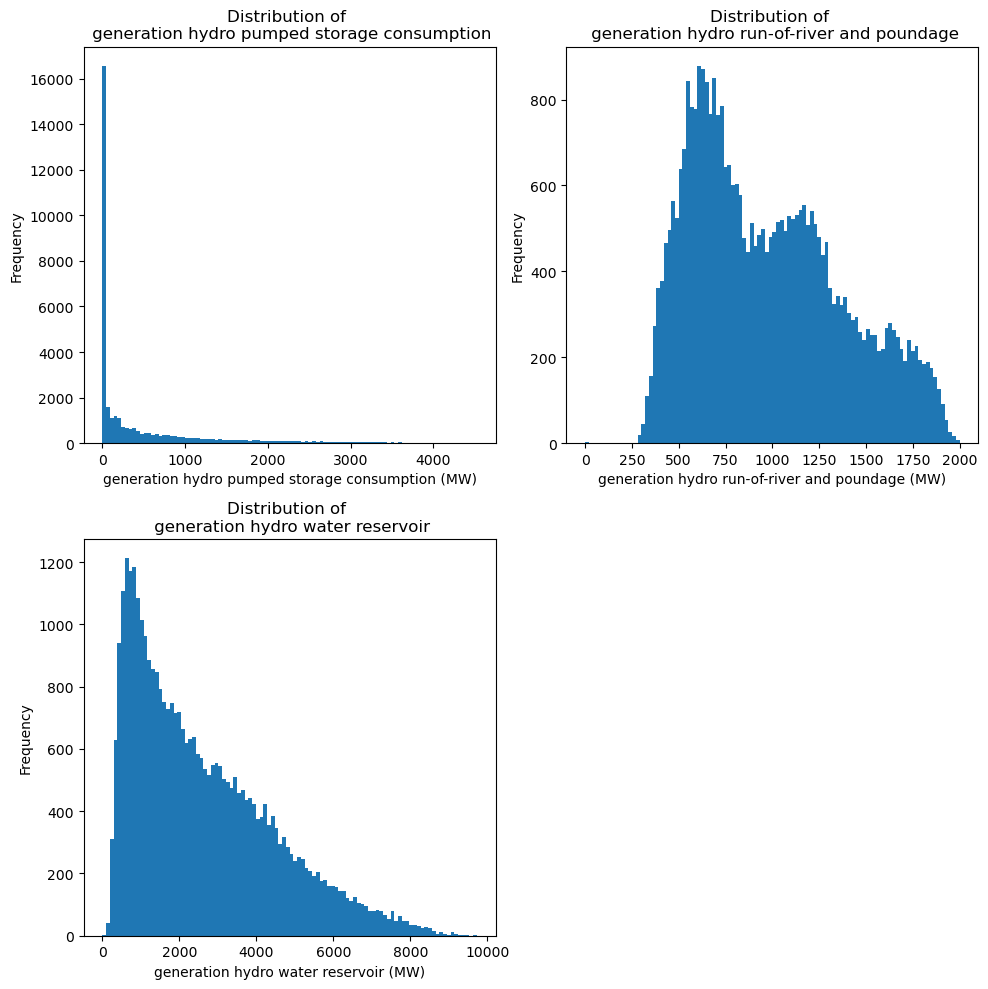

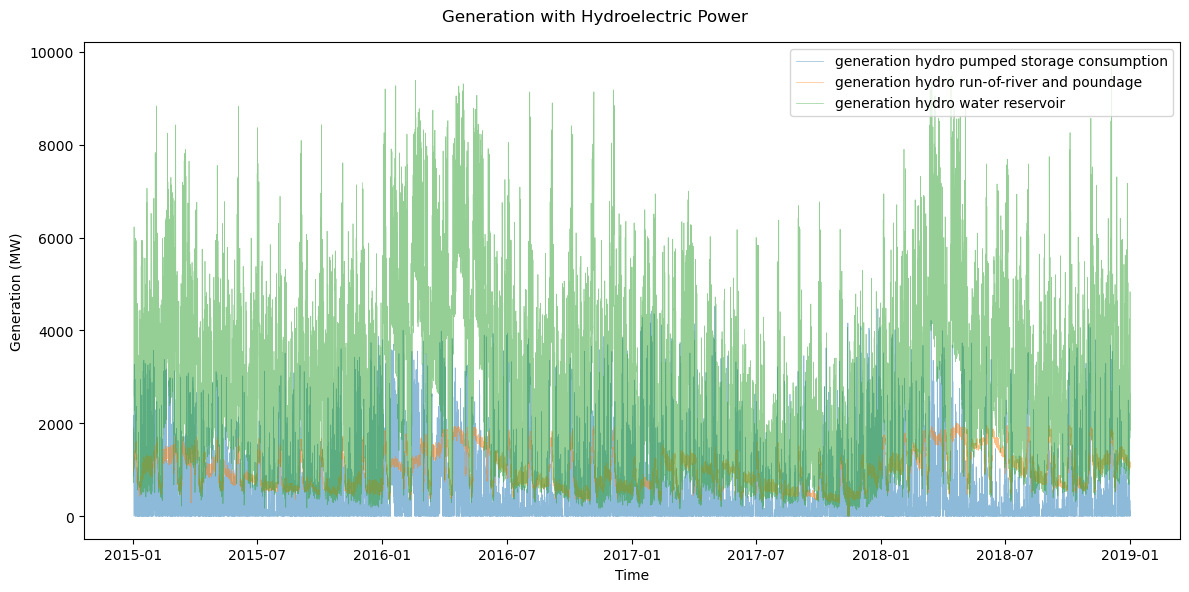

generation hydro pumped storage consumption  \
count                                 35045.000000   
mean                                    475.577343   
std                                     792.406614   
min                                       0.000000   
25%                                       0.000000   
50%                                      68.000000   
75%                                     616.000000   
max                                    4523.000000   

       generation hydro run-of-river and poundage  \
count                                35045.000000   
mean                                   972.116108   
std                                    400.777536   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation hydro water reservoir  
count                      35046.000000  
mean                        2605.114735  
std                         1835.199745  
min                            0.000000  
25%                         1077.250000  
50%                         2164.000000  
75%                         3757.000000  
max                         9728.000000

In [52]:
plot_energy_histograms(he_df, he_col)
plot_linegraphs(he_df, he_col, "Time", "Generation (MW)", "Generation with Hydroelectric Power")
he_df[he_col].describe()

From the outputs above:

**Water reservoirs** provide the bulk of hydroelectric generation due to their ability to store large volumes of water, making them more reliable compared to the other two hydro sources. This reliability is reflected in the line plot. Additionally, water reservoirs offer high flexibility, as operators can decide when to release water to generate power based on demand and water availability. This flexibility is evident in the histogram, which is right-skewed.

**Hydro pumped storage** involves pumping water uphill into a reservoir during periods of low electricity demand and releasing it to generate electricity during high demand periods. This operation explains the high variability observed in both the line plot and the histogram. Hydro pumped storage is primarily used to balance short-term grid fluctuations rather than for continuous operations, which accounts for the spikes near zero in the histogram.

**Hydro run-of-river and poundage** rely on the natural flow and height of rivers. The distribution observed is likely influenced by changing river conditions, such as seasonal rains and snowmelt. To improve the model, incorporating features related to rainfall or snowfall could be beneficial.

**Sources:**
- https://www.iea.org/news/hydropower-has-a-crucial-role-in-accelerating-clean-energy-transitions-to-achieve-countries-climate-ambitions-securely
- https://www.hydropower.org/iha/discover-types-of-hydropower
- https://www.energy.gov/eere/water/pumped-storage-hydropower#:~:text=Pumped%20storage%20hydropower%20(PSH)%20is,)%2C%20passing%20through%20a%20turbine.
- https://documents1.worldbank.org/curated/en/926391632392943578/pdf/Hydropower-and-Dams-H-and-D-Strengthening-Climate-Informed-Project-Design.pdf

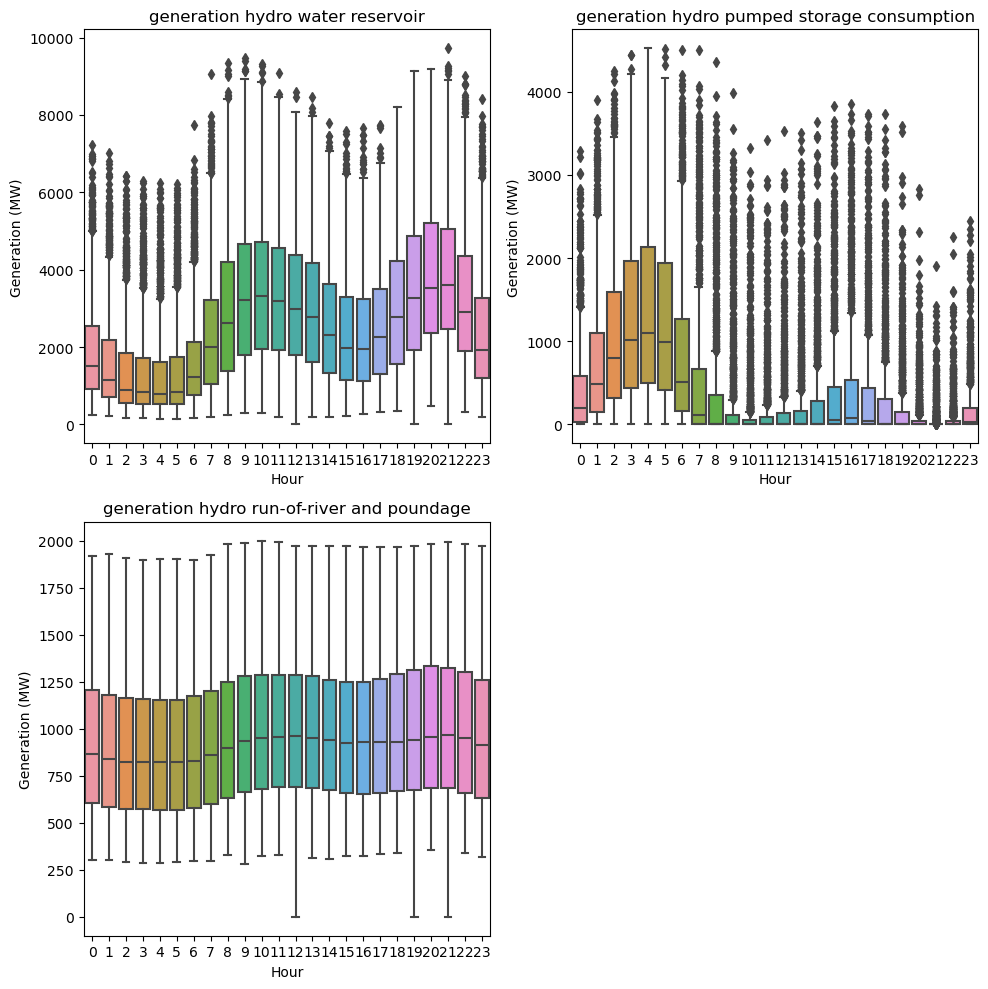

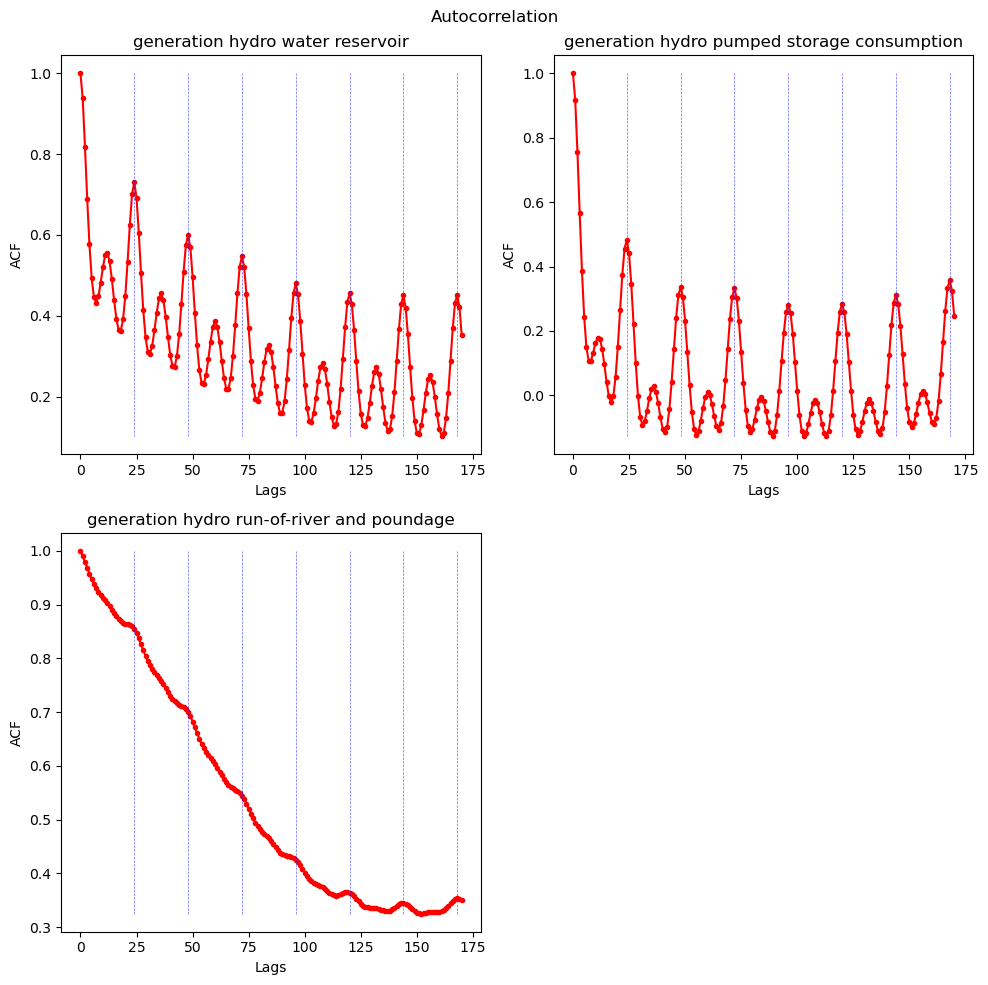

In [53]:
he_df['hour'] = he_df.index.hour
he_col = ['generation hydro water reservoir', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage']
plot_gen_boxplots(he_df[he_df["isHoliday"]==0], he_col)
plot_acf_pacf_group(he_df[he_df["isHoliday"]==0], he_col)

**For Generation Hydro Water Reservoir**

The boxplot reveals significant variability throughout the day for hydro water reservoir generation, with peaks in the early morning and evening hours and a dip in the middle of the day. Consistent outliers are observed, particularly in the early morning and late evening. The ACF plot shows strong autocorrelation with clear peaks, indicating strong daily seasonality. Based on these observations, it is suggested to impute missing values from the target variable using data from the previous day.

**For Generation Hydro Pumped Storage Consumption**

The boxplot for hydro pumped storage consumption shows high variability during the early hours, with a decreasing trend throughout the day. There is a notable number of outliers, especially in the early hours. The ACF plot indicates strong daily seasonality with repetitive patterns, reflecting consistent usage. Given these results, it is recommended to impute missing values based on a time-of-day context, such as using the median of the last 12 p.m. values from the past three days.

**For Generation Hydro Run-of-River and Poundage**

The boxplot for hydro run-of-river and poundage shows less variability compared to other generation types, with a slight dip around midday and consistent generation throughout the day. There are fewer outliers, and the data appears relatively stable. The ACF plot indicates a gradual decline in autocorrelation, suggesting a stable trend with weak seasonality. For imputing missing values, it is advisable to use a time-of-day context, such as the median of the last 12 p.m. values from the past three days.

### 3.3.1 Imputation

In [54]:
col_dict = {'generation hydro water reservoir':1}
for col in list(col_dict.keys()):
    he_df[col] = impute_previous_n_days(he_df.copy()[col], col_dict[col])  

col_dict_median = {'generation hydro pumped storage consumption':3, 'generation hydro run-of-river and poundage':3}
for col in list(col_dict_median.keys()):
    he_df[col] = impute_stat_n_days(he_df.copy()[col], col_dict_median[col], np.median)

missing_features(he_df)

Empty DataFrame
Columns: [Missing (%), Missing (Count)]
Index: []

All missing data in the three hydroelectrical power generation features are handled!

In [55]:
for col in he_col:
    df[col] = he_df[col]

## 3.4 Nuclear

In [56]:
n_col = ['generation nuclear']
n_df = df[n_col].copy()
n_df = is_weekday(n_df)
n_df = is_holidays(n_df, n_df.index.year.unique())
n_df.loc[n_df[n_col].isna().any(axis=1)]

generation nuclear  isWeekday  isHoliday
time                                                               
2015-01-05 03:00:00+01:00                 NaN        1.0          0
2015-01-05 12:00:00+01:00                 NaN        1.0          0
2015-01-05 13:00:00+01:00                 NaN        1.0          0
2015-01-05 14:00:00+01:00                 NaN        1.0          0
2015-01-05 15:00:00+01:00                 NaN        1.0          0
2015-01-05 16:00:00+01:00                 NaN        1.0          0
2015-01-05 17:00:00+01:00                 NaN        1.0          0
2015-01-19 19:00:00+01:00                 NaN        1.0          0
2015-01-19 20:00:00+01:00                 NaN        1.0          0
2015-01-27 19:00:00+01:00                 NaN        1.0          0
2015-01-28 13:00:00+01:00                 NaN        1.0          0
2015-04-16 09:00:00+02:00                 NaN        1.0          0
2015-04-23 21:00:00+02:00                 NaN        1.0          0
2015-06-15 09:00:00+02:00                 NaN        1.0          0
2015-10-02 11:00:00+02:00                 NaN        1.0          0
2015-12-02 09:00:00+01:00                 NaN        1.0          0
2018-07-11 09:00:00+02:00                 NaN        1.0          0

**Note:** None of the missing data is on a holiday.

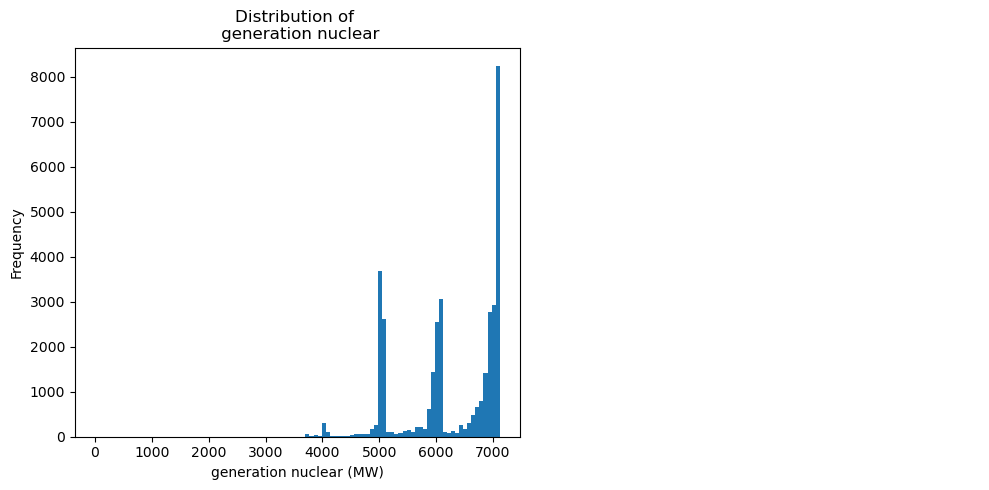

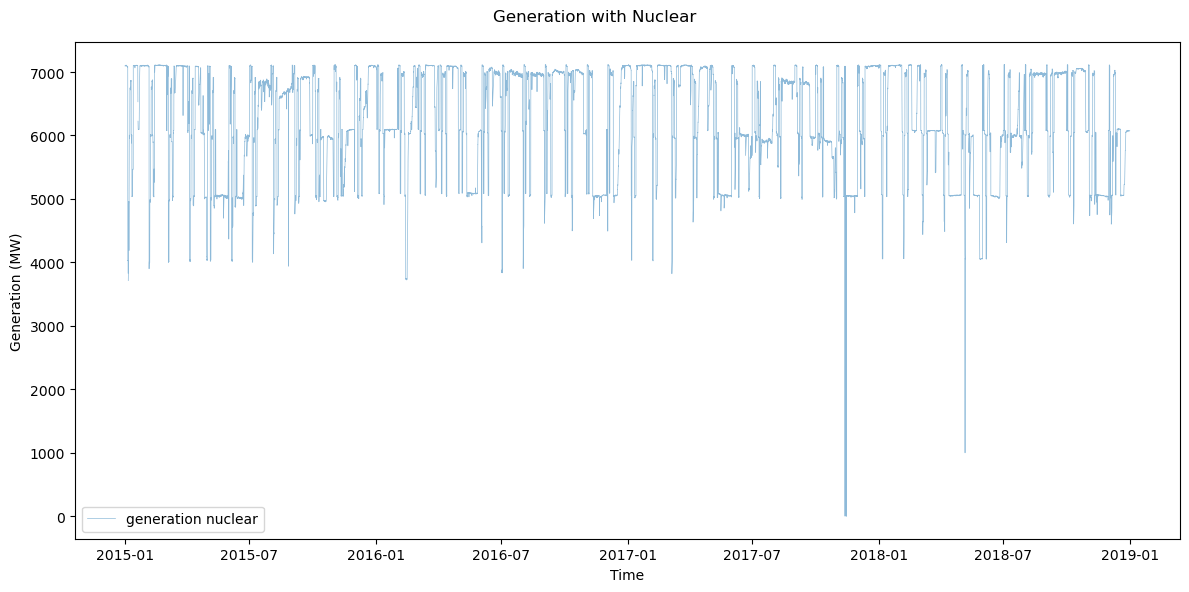

generation nuclear
count        35047.000000
mean          6263.907039
std            839.667958
min              0.000000
25%           5760.000000
50%           6566.000000
75%           7025.000000
max           7117.000000

In [57]:
plot_energy_histograms(n_df, n_col)
plot_linegraphs(n_df, n_col, "Time", "Generation (MW)", "Generation with Nuclear")
n_df[n_col].describe()

From the outputs above:

Generation from nuclear sources primarily operates within a narrow range of high outputs, with several distinct peaks in the data, most notably around 7,000 MW. The line plot demonstrates that nuclear generation is relatively stable and consistently high over time. The significant drops observed in late 2017 and mid-2018 are likely due to maintenance periods, such as refueling. The consistent performance of nuclear generation is probably a result of its limited ramping ability.

**Sources:**
- https://www.nrc.gov/reading-rm/basic-ref/students/science-101/how-does-nuclear-power-plant-make-electricity.html
- https://world-nuclear.org/information-library/current-and-future-generation/nuclear-power-in-the-world-today
- https://www.iaea.org/sites/default/files/19/02/the-nuclear-fuel-cycle.pdf

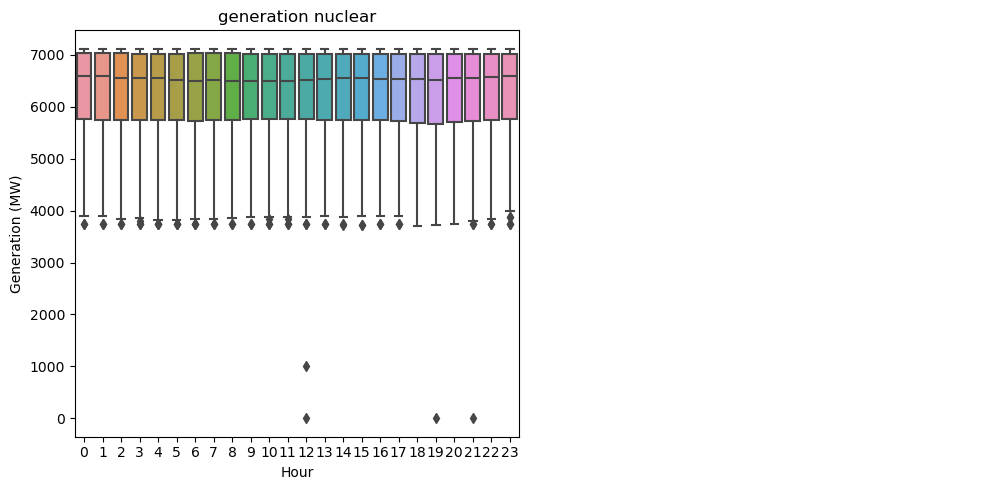

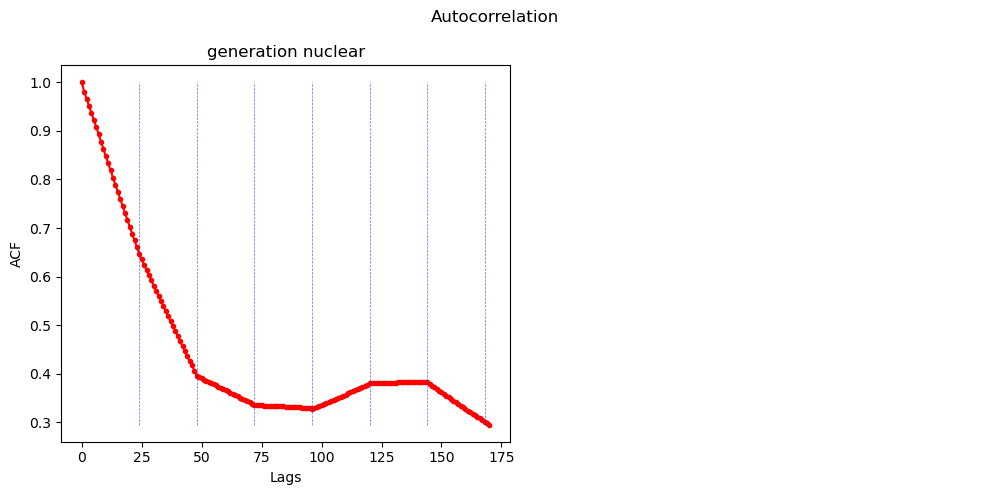

In [58]:
n_df['hour'] = n_df.index.hour
plot_gen_boxplots(n_df[n_df["isHoliday"]==0], n_col)
plot_acf_pacf_group(n_df[n_df["isHoliday"]==0], n_col)

**For Generation Nuclear**

The boxplot indicates that nuclear generation is relatively stable across all hours, with minimal variability. Most values are concentrated around 6,500 to 7,500 MW, though there are a few low outliers significantly below this typical range. The ACF plot shows a gradual decline in autocorrelation, suggesting a stable pattern with no strong seasonality or trends. Based on these observations, it is advisable to impute missing values using a time-of-day context, such as the mean of the last 12 p.m. values from the past two days.

### 3.4.1 Imputation

In [59]:
col_dict_mean = {'generation nuclear':2}
for col in list(col_dict_mean.keys()):
    n_df[col] = impute_stat_n_days(n_df.copy()[col], col_dict_mean[col], np.mean)

missing_features(n_df)

Empty DataFrame
Columns: [Missing (%), Missing (Count)]
Index: []

All missing data for nuclear generation has been addressed!

In [60]:
for col in n_col:
    df[col] = n_df[col]

## 3.5 Other Sources

In [61]:
o_col = ['generation other', 'generation waste']
o_df = df[o_col].copy()
o_df = is_weekday(o_df)
o_df = is_holidays(o_df, o_df.index.year.unique())
o_df.loc[o_df[o_col].isna().any(axis=1)]

generation other  generation waste  isWeekday  \
time                                                                       
2015-01-05 03:00:00+01:00               NaN               NaN        1.0   
2015-01-05 12:00:00+01:00               NaN               NaN        1.0   
2015-01-05 13:00:00+01:00               NaN               NaN        1.0   
2015-01-05 14:00:00+01:00               NaN               NaN        1.0   
2015-01-05 15:00:00+01:00               NaN               NaN        1.0   
2015-01-05 16:00:00+01:00               NaN               NaN        1.0   
2015-01-05 17:00:00+01:00               NaN               NaN        1.0   
2015-01-19 19:00:00+01:00               NaN               NaN        1.0   
2015-01-19 20:00:00+01:00               NaN               NaN        1.0   
2015-01-27 19:00:00+01:00               NaN               NaN        1.0   
2015-01-28 13:00:00+01:00               NaN               NaN        1.0   
2015-04-16 09:00:00+02:00               NaN               NaN        1.0   
2015-04-23 21:00:00+02:00               NaN               NaN        1.0   
2015-06-15 09:00:00+02:00               NaN               NaN        1.0   
2015-10-02 11:00:00+02:00               NaN               NaN        1.0   
2015-12-02 09:00:00+01:00               NaN               NaN        1.0   
2016-04-13 05:00:00+02:00              53.0               NaN        1.0   
2016-07-09 22:00:00+02:00               NaN               NaN        0.0   
2018-07-11 09:00:00+02:00               NaN               NaN        1.0   

                           isHoliday  
time                                  
2015-01-05 03:00:00+01:00          0  
2015-01-05 12:00:00+01:00          0  
2015-01-05 13:00:00+01:00          0  
2015-01-05 14:00:00+01:00          0  
2015-01-05 15:00:00+01:00          0  
2015-01-05 16:00:00+01:00          0  
2015-01-05 17:00:00+01:00          0  
2015-01-19 19:00:00+01:00          0  
2015-01-19 20:00:00+01:00          0  
2015-01-27 19:00:00+01:00          0  
2015-01-28 13:00:00+01:00          0  
2015-04-16 09:00:00+02:00          0  
2015-04-23 21:00:00+02:00          0  
2015-06-15 09:00:00+02:00          0  
2015-10-02 11:00:00+02:00          0  
2015-12-02 09:00:00+01:00          0  
2016-04-13 05:00:00+02:00          0  
2016-07-09 22:00:00+02:00          0  
2018-07-11 09:00:00+02:00          0

**Note:** None of the missing data is on a holiday.

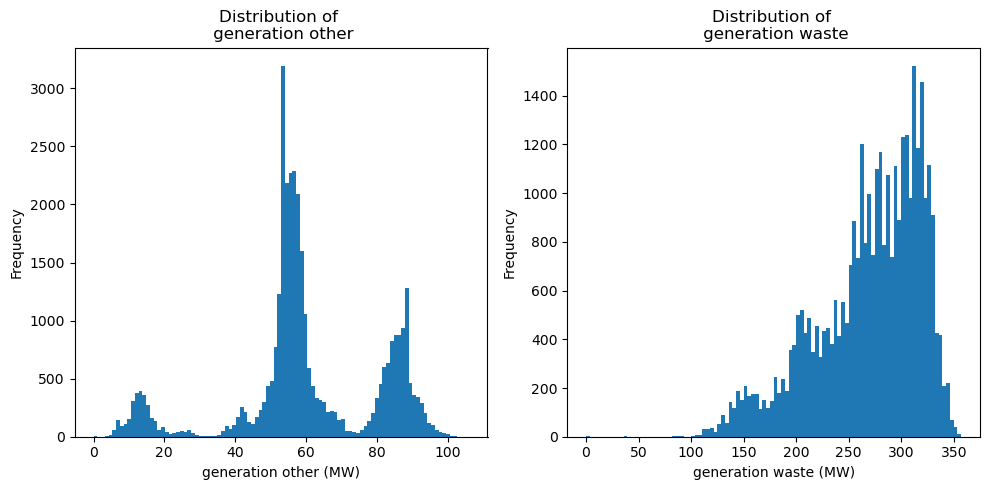

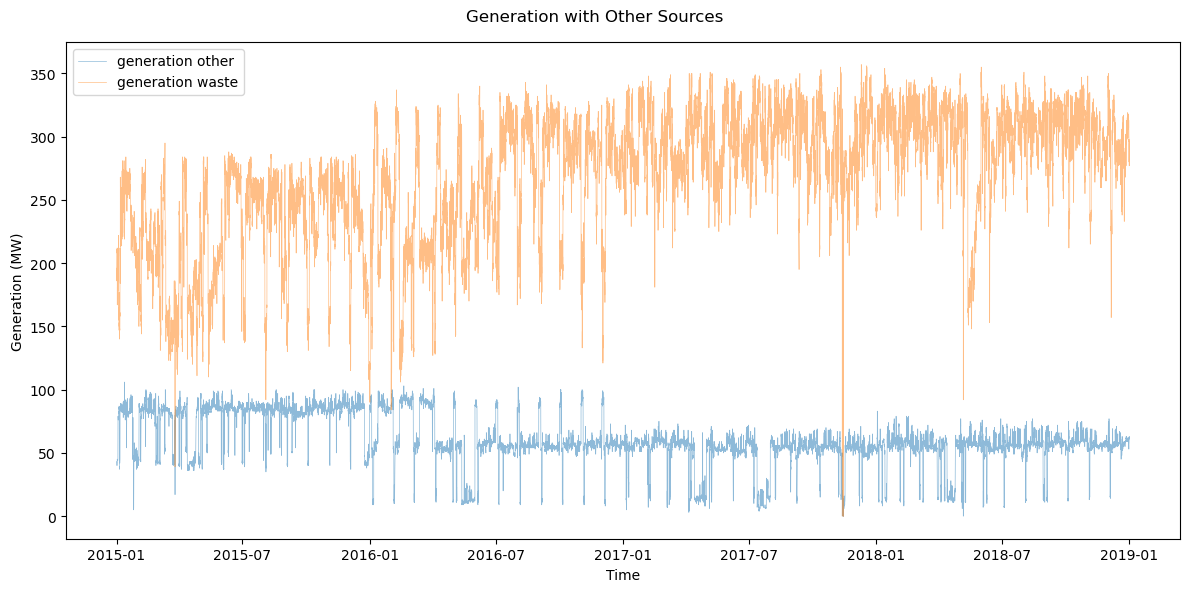

generation other  generation waste
count      35046.000000      35045.000000
mean          60.228585        269.452133
std           20.238381         50.195536
min            0.000000          0.000000
25%           53.000000        240.000000
50%           57.000000        279.000000
75%           80.000000        310.000000
max          106.000000        357.000000

In [62]:
plot_energy_histograms(o_df, o_col)
plot_linegraphs(o_df, o_col, "Time", "Generation (MW)", "Generation with Other Sources")
o_df[o_col].describe()

From the outputs above:

Generation from waste appears to involve converting solid waste into electricity, such as agricultural waste. The line plot indicates that it provides consistent power output, although at a relatively low level. This is likely due to its reliance on a steady stream of waste material. Additionally, waste-to-energy plants typically operate as baseload generators, meaning they run continuously but cannot quickly adjust their power output, with their maximum generation limited by the amount of waste available for processing.

In contrast, the 'other' electricity generation source, as observed from the histogram and line plot, seems to be a source that is being gradually phased out.

**Sources:**
- https://www.eia.gov/energyexplained/biomass/waste-to-energy-in-depth.php
- https://unfccc.int/sites/default/files/resource/Waste%20to%20energy%202.pdf 

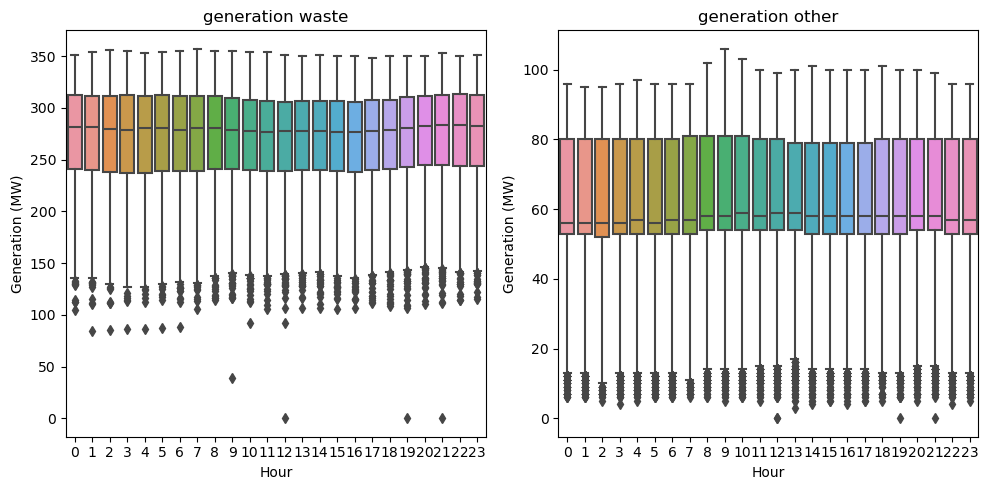

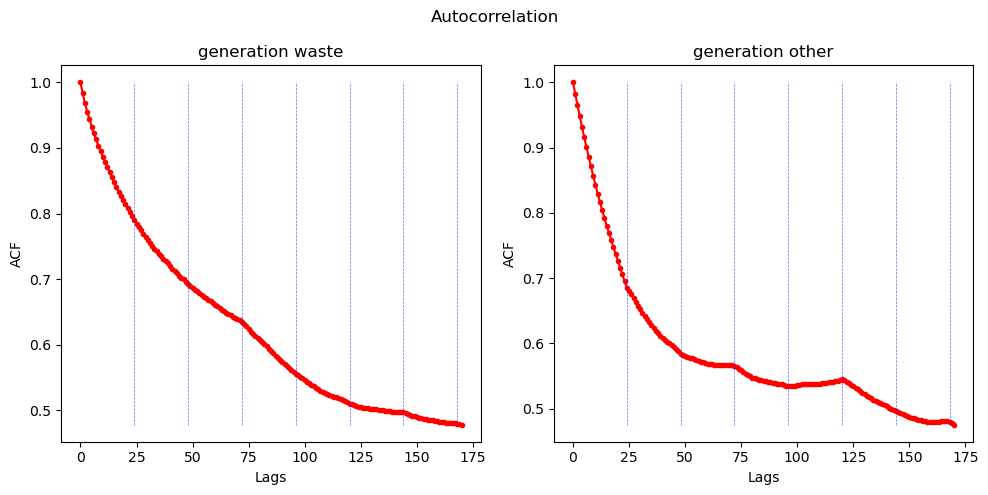

In [63]:
o_df['hour'] = o_df.index.hour
o_col = ['generation waste', 'generation other']
plot_gen_boxplots(o_df[o_df["isHoliday"]==0], o_col)
plot_acf_pacf_group(o_df[o_df["isHoliday"]==0], o_col)

**For Generation Waste**

The boxplot reveals a consistent generation pattern throughout the day with moderate variability. There are numerous outliers, particularly on the lower end, indicating occasional drops in generation. The ACF plot shows a steady decline in autocorrelation, suggesting consistent generation with a weak trend. Based on these observations, it is recommended to impute missing values using a time-of-day context, such as the median of the last 12 p.m. values from the past three days.

**For Generation Other**

The boxplot for the 'other' generation category shows relatively low variability, with consistent generation across all hours. Many outliers are observed, mostly lower than the usual generation levels. The ACF plot indicates a steady decrease in autocorrelation, suggesting stable generation without significant seasonality. To address missing values, it is advisable to use a time-of-day context, such as the mean of the last 12 p.m. values from the past two days.

### 3.5.1 Imputation

In [64]:
col_dict_median = {'generation waste':3}
for col in list(col_dict_median.keys()):
    o_df[col] = impute_stat_n_days(o_df.copy()[col], col_dict_median[col], np.median)

col_dict_mean = {'generation other':2}
for col in list(col_dict_mean.keys()):
    o_df[col] = impute_stat_n_days(o_df.copy()[col], col_dict_mean[col], np.mean)

missing_features(o_df)

Empty DataFrame
Columns: [Missing (%), Missing (Count)]
Index: []

All missing data has been addressed!

In [65]:
for col in o_col:
    df[col] = o_df[col]

# 4.0 Final Notes

In [66]:
missing_features(df)

Empty DataFrame
Columns: [Missing (%), Missing (Count)]
Index: []

For a sanity check, our energy dataset is now clean.

**Note:** The imputation methods chosen for each column may not be optimal but were selected for their simplicity and effectiveness in preserving the original data distribution and temporal trends. Since none of the missing values occur on holidays, we initially attempted to impute using values from non-holiday periods.

Having addressed all the features, let’s now examine the Pearson correlation to identify any linear relationships, especially concerning the generation features.

In [67]:
corr = df.corr(method='pearson')
abs(corr[(corr>0.7) & (corr < 1)]).stack()

generation fossil brown coal/lignite  generation fossil hard coal             0.76872
generation fossil hard coal           generation fossil brown coal/lignite    0.76872
dtype: float64

Based on our analysis of the data, we’ve observed very low correlation among the different types of generation. This low correlation can be attributed to the distinct priorities and constraints associated with each generation type used to meet electricity demand. Each generation method is chosen based on specific factors such as resource availability, cost considerations, and operational characteristics. For instance, wind and solar power depend heavily on natural conditions, while fossil fuels and hydroelectric sources are utilized for their reliability and capacity. These operational priorities and constraints contribute to the observed low correlations, as each generation type fulfills different roles and reacts differently to varying demand and environmental factors.

Interestingly, there is a strong linear correlation between the two generation types involving coal.

In [68]:
save_file(df, "energy_dataset_clean.csv")

File is saved.
